<a href="https://colab.research.google.com/github/softmurata/colab_notebooks/blob/main/semantic_segmentation/mmseg_tutorial_deeplabv3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
torch.__version__

'1.13.1+cu116'

In [ ]:
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu116/torch1.13.1/index.html

In [ ]:
!rm -rf mmsegmentation
!git clone https://github.com/open-mmlab/mmsegmentation.git 
%cd mmsegmentation
!pip install -e .

In [ ]:
import os

DATA_DIR = '/content/data/CamVid/'

# load repo with data if it is not exists
if not os.path.exists(DATA_DIR):
    print('Loading data...')
    os.system('git clone https://github.com/alexgkendall/SegNet-Tutorial /content/data')
    print('Done!')

In [ ]:
#学習済みモデルの入手
%cd /content/mmsegmentation
!mkdir checkpoints
!wget https://download.openmmlab.com/mmsegmentation/v0.5/pspnet/pspnet_r50-d8_512x1024_40k_cityscapes/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth -P checkpoints

In [ ]:
#mmsegmentationのモジュールの呼び出し

from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot
from mmseg.core.evaluation import get_palette

In [ ]:
#モデルの選択、および学習済みモデルの呼び出し
config_file = 'configs/pspnet/pspnet_r50-d8_512x1024_40k_cityscapes.py'
checkpoint_file = 'checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth'

#mmsegmentationの実行（GPUあり）
model = init_segmentor(config_file, checkpoint_file, device='cuda:0')

In [ ]:
# test a single image
img = 'demo/demo.png'
result = inference_segmentor(model, img)

# show the results
show_result_pyplot(model, img, result, get_palette('cityscapes'))

In [8]:
#@title 今回の車載カメラ
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as plt

In [ ]:
# Let's take a look at the dataset
import mmcv

img = mmcv.imread('/content/data/CamVid/train/0001TP_006690.png')
print(img.shape)
plt.figure(figsize=(8, 6))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

In [ ]:
# test a single image
img = '/content/data/CamVid/train/0001TP_006690.png'
result = inference_segmentor(model, img)

show_result_pyplot(model, img, result, get_palette('cityscapes'))

In [ ]:
# Let's take a look at the segmentation map we got
from PIL import Image
import matplotlib.patches as mpatches
img = Image.open('/content/data/CamVid/trainannot/0001TP_006690.png')
plt.figure(figsize=(8, 6))
img_p = np.array(img.convert('P'))
plt.imshow(np.array(img.convert('P'))) #'RGB'

plt.show()

In [ ]:
img_p.shape

In [13]:
#@title training
import os.path as osp
import numpy as np
from PIL import Image
# convert dataset annotation to semantic segmentation map
data_root = '/content/data/CamVid'
img_dir = 'train'
ann_dir = 'trainannot'
# define class and plaette for better visualization
classes = ('sky', 'Bulding', 'Pole', 'Road_marking', 'Road', 'Pavement', 'Tree', 'SingSymbole','Fence', 'Car', 'Pedestrian', 'Bicyclist', 'Unlabeled')
palette = [[128,128,128], [128,0,0], [192,192,128], [255,69,0], [128,64,128], [60,40,222], [128,128,0], [192,128,128], [64,64,128], [64,0,128], [64,64,0], [0,128,192], [0,0,0]]

In [14]:
# split train/val set randomly
import mmcv
split_dir = 'splits_resnet50A'
mmcv.mkdir_or_exist(osp.join(data_root, split_dir))
filename_list = [osp.splitext(filename)[0] for filename in mmcv.scandir(
    osp.join(data_root, ann_dir), suffix='.png')]
with open(osp.join(data_root, split_dir, 'train.txt'), 'w') as f:
  # select first 4/5 as train set
  train_length = int(len(filename_list)*4/5)
  f.writelines(line + '\n' for line in filename_list[:train_length])
with open(osp.join(data_root, split_dir, 'val.txt'), 'w') as f:
  # select last 1/5 as train set
  f.writelines(line + '\n' for line in filename_list[train_length:])

In [15]:
# convert dataset for mmsegmentation
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset

@DATASETS.register_module()
class splits_resnet50A(CustomDataset):
  CLASSES = classes
  PALETTE = palette
  def __init__(self, split, **kwargs):
    super().__init__(img_suffix='.png', seg_map_suffix='.png', 
                     split=split, **kwargs)
    assert osp.exists(self.img_dir) and self.split is not None

In [ ]:
%cd /content/mmsegmentation

In [16]:
# create config
from mmcv import Config
cfg = Config.fromfile('configs/pspnet/pspnet_r50-d8_512x1024_40k_cityscapes.py')

In [ ]:
# config check
print(f'Config:\n{cfg.pretty_text}')

In [ ]:
# if you encounter assertion error, you should restart.. read configuration at once

In [ ]:
from mmseg.apis import set_random_seed
from mmseg.utils import get_device
import mmcv

img = mmcv.imread('/content/data/CamVid/train/0001TP_006690.png')
h = img.shape[0]
w = img.shape[1]

# add CLASSES and PALETTE to checkpoint
cfg.checkpoint_config.meta = dict(
   CLASSES=classes,
 PALETTE=palette)

# Since we use ony one GPU, BN is used instead of SyncBN
cfg.norm_cfg = dict(type='BN', requires_grad=True)
cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg
# modify num classes of the model in decode/auxiliary head
cfg.model.decode_head.num_classes = len(classes) #8
cfg.model.auxiliary_head.num_classes = len(classes) #8

# Modify dataset type and path
cfg.dataset_type = 'splits_resnet50A'
cfg.data_root = data_root

cfg.data.samples_per_gpu = 8
cfg.data.workers_per_gpu=8

cfg.img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
cfg.crop_size = (256, 256)
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(w, h), ratio_range=(0.5, 2.0)),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(type='Normalize', **cfg.img_norm_cfg),
    dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(w, h),
        # img_ratios=[0.5, 0.75, 1.0, 1.25, 1.5, 1.75],
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(type='Normalize', **cfg.img_norm_cfg),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]


cfg.data.train.type = cfg.dataset_type
cfg.data.train.data_root = cfg.data_root
cfg.data.train.img_dir = img_dir
cfg.data.train.ann_dir = ann_dir
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = 'splits_resnet50A/train.txt'

cfg.data.val.type = cfg.dataset_type
cfg.data.val.data_root = cfg.data_root
cfg.data.val.img_dir = img_dir
cfg.data.val.ann_dir = ann_dir
cfg.data.val.pipeline = cfg.test_pipeline
cfg.data.val.split = 'splits_resnet50A/val.txt'

cfg.data.test.type = cfg.dataset_type
cfg.data.test.data_root = cfg.data_root
cfg.data.test.img_dir = img_dir
cfg.data.test.ann_dir = ann_dir
cfg.data.test.pipeline = cfg.test_pipeline
cfg.data.test.split = 'splits_resnet50A/val.txt'

# We can still use the pre-trained Mask RCNN model though we do not need to
# use the mask branch
#cfg.load_from = 'checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './work_dirs/tutorial_pspnet_r50A'

cfg.total_iters = 100  # ToDo: change
cfg.log_config.interval = 10
cfg.evaluation.interval = 200
cfg.checkpoint_config.interval = 1000

# Set seed to facitate reproducing the result
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)
cfg.device = get_device()

# Please check this file(https://mmsegmentation.readthedocs.io/en/latest/tutorials/config.html)
cfg.runner.max_iters=400 # Total number of iterations. For EpochBasedRunner use `max_epochs`

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

In [ ]:
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor


# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_segmentor(cfg.model)
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True, 
                meta=dict())

2023-02-13 00:28:11,635 - mmseg - INFO - Loaded 293 images
/content/mmsegmentation/mmseg/models/backbones/resnet.py:431: UserWarning: DeprecationWarning: pretrained is a deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is a deprecated, '
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
2023-02-13 00:28:13,031 - mmseg - INFO - Loaded 74 images
2023-02-13 00:28:13,033 - mmseg - INFO - Start running, host: root@1d045eca5962, work_dir: /content/mmsegmentation/work_dirs/tutorial_pspnet_r50A
2023-02-13 00:28:13,037 - mmseg - INFO - Ho

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 12.7 task/s, elapsed: 6s, ETA:     0s

2023-02-13 00:30:30,970 - mmseg - INFO - per class results:
2023-02-13 00:30:30,974 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 79.46 | 83.47 |
|   Bulding    | 52.35 | 64.53 |
|     Pole     |  0.0  |  0.0  |
| Road_marking | 81.55 | 98.87 |
|     Road     |  9.72 | 10.16 |
|   Pavement   | 33.48 | 65.52 |
|     Tree     |  0.0  |  0.0  |
| SingSymbole  |  0.0  |  0.0  |
|    Fence     | 31.36 | 70.37 |
|     Car      |  0.0  |  0.0  |
|  Pedestrian  |  0.0  |  0.0  |
|  Bicyclist   |  2.99 |  3.2  |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 00:30:30,975 - mmseg - INFO - Summary:
2023-02-13 00:30:30,977 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 70.86 | 24.24 | 33.01 |
+-------+-------+-------+
2023-02-13 00:30:30,980 - mmseg - INFO - Iter(val) [74]	aAcc: 0.7086, mIoU: 0.2424, mAcc: 0.3301, IoU.sky: 0.7946, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 12.3 task/s, elapsed: 6s, ETA:     0s

2023-02-13 00:32:51,591 - mmseg - INFO - per class results:
2023-02-13 00:32:51,595 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 84.06 | 96.04 |
|   Bulding    | 53.78 | 72.69 |
|     Pole     |  0.0  |  0.0  |
| Road_marking | 84.18 | 97.49 |
|     Road     | 23.09 |  24.7 |
|   Pavement   | 29.07 | 53.26 |
|     Tree     |  0.0  |  0.0  |
| SingSymbole  |  0.76 |  0.78 |
|    Fence     | 46.41 | 61.85 |
|     Car      |  0.67 |  0.69 |
|  Pedestrian  |  0.0  |  0.0  |
|  Bicyclist   |  5.88 |  6.69 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 00:32:51,596 - mmseg - INFO - Summary:
2023-02-13 00:32:51,601 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 73.72 | 27.32 | 34.52 |
+-------+-------+-------+
2023-02-13 00:32:51,602 - mmseg - INFO - Iter(val) [74]	aAcc: 0.7372, mIoU: 0.2732, mAcc: 0.3452, IoU.sky: 0.8406, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 13.5 task/s, elapsed: 5s, ETA:     0s

2023-02-13 00:35:08,605 - mmseg - INFO - per class results:
2023-02-13 00:35:08,609 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 86.55 | 92.83 |
|   Bulding    | 64.51 | 76.28 |
|     Pole     |  0.0  |  0.0  |
| Road_marking | 87.63 | 95.72 |
|     Road     | 40.84 | 49.06 |
|   Pavement   | 52.57 | 81.72 |
|     Tree     |  0.0  |  0.0  |
| SingSymbole  |  6.96 |  7.79 |
|    Fence     | 43.88 | 93.18 |
|     Car      |  3.67 |  4.28 |
|  Pedestrian  |  0.04 |  0.04 |
|  Bicyclist   |  4.55 |  4.78 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 00:35:08,610 - mmseg - INFO - Summary:
2023-02-13 00:35:08,613 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 79.02 | 32.6 | 42.14 |
+-------+------+-------+
2023-02-13 00:35:08,615 - mmseg - INFO - Iter(val) [74]	aAcc: 0.7902, mIoU: 0.3260, mAcc: 0.4214, IoU.sky: 0.8655, IoU.B

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 12.2 task/s, elapsed: 6s, ETA:     0s

2023-02-13 00:37:29,326 - mmseg - INFO - per class results:
2023-02-13 00:37:29,332 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 87.28 | 97.01 |
|   Bulding    | 73.28 | 85.31 |
|     Pole     |  0.68 |  0.69 |
| Road_marking | 89.17 | 96.45 |
|     Road     |  42.8 | 48.12 |
|   Pavement   | 57.35 | 80.58 |
|     Tree     |  1.68 |  1.7  |
| SingSymbole  | 16.57 | 22.98 |
|    Fence     | 52.52 | 88.84 |
|     Car      |  1.54 |  1.62 |
|  Pedestrian  |  0.69 |  0.77 |
|  Bicyclist   | 10.98 | 13.19 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 00:37:29,334 - mmseg - INFO - Summary:
2023-02-13 00:37:29,338 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 82.19 | 36.21 | 44.77 |
+-------+-------+-------+
2023-02-13 00:37:29,341 - mmseg - INFO - Iter(val) [74]	aAcc: 0.8219, mIoU: 0.3621, mAcc: 0.4477, IoU.sky: 0.8728, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 13.3 task/s, elapsed: 6s, ETA:     0s

2023-02-13 00:39:48,863 - mmseg - INFO - per class results:
2023-02-13 00:39:48,866 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 88.22 | 95.41 |
|   Bulding    | 72.89 | 90.89 |
|     Pole     |  2.13 |  2.21 |
| Road_marking | 90.94 | 94.37 |
|     Road     | 56.34 | 71.64 |
|   Pavement   |  60.4 | 79.02 |
|     Tree     |  5.43 |  5.62 |
| SingSymbole  | 18.73 | 28.31 |
|    Fence     | 61.34 | 79.93 |
|     Car      |  7.97 | 12.28 |
|  Pedestrian  | 16.51 | 27.37 |
|  Bicyclist   | 15.49 | 19.59 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 00:39:48,869 - mmseg - INFO - Summary:
2023-02-13 00:39:48,872 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 83.57 | 41.37 | 50.55 |
+-------+-------+-------+
2023-02-13 00:39:48,874 - mmseg - INFO - Iter(val) [74]	aAcc: 0.8357, mIoU: 0.4137, mAcc: 0.5055, IoU.sky: 0.8822, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 12.1 task/s, elapsed: 6s, ETA:     0s

2023-02-13 00:42:09,228 - mmseg - INFO - per class results:
2023-02-13 00:42:09,233 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      |  84.1 | 85.58 |
|   Bulding    | 75.21 | 87.01 |
|     Pole     |  3.07 |  3.18 |
| Road_marking |  93.8 | 96.96 |
|     Road     | 64.97 | 76.89 |
|   Pavement   | 53.11 | 91.08 |
|     Tree     | 11.54 | 12.55 |
| SingSymbole  | 28.05 | 35.75 |
|    Fence     | 71.69 | 88.23 |
|     Car      | 12.41 | 16.54 |
|  Pedestrian  | 18.33 | 23.55 |
|  Bicyclist   | 24.31 | 29.49 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 00:42:09,234 - mmseg - INFO - Summary:
2023-02-13 00:42:09,236 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 84.28 | 45.05 | 53.9 |
+-------+-------+------+
2023-02-13 00:42:09,239 - mmseg - INFO - Iter(val) [74]	aAcc: 0.8428, mIoU: 0.4505, mAcc: 0.5390, IoU.sky: 0.8410, IoU.B

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 13.0 task/s, elapsed: 6s, ETA:     0s

2023-02-13 00:44:26,962 - mmseg - INFO - per class results:
2023-02-13 00:44:26,965 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 87.01 | 92.94 |
|   Bulding    | 70.03 | 96.34 |
|     Pole     |  7.95 | 11.12 |
| Road_marking | 90.63 |  92.0 |
|     Road     | 51.94 | 74.25 |
|   Pavement   | 57.11 | 64.58 |
|     Tree     | 16.75 | 18.99 |
| SingSymbole  |  27.8 | 44.45 |
|    Fence     | 67.17 | 73.85 |
|     Car      | 15.39 | 22.62 |
|  Pedestrian  | 11.99 | 21.38 |
|  Bicyclist   | 23.83 | 30.82 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 00:44:26,967 - mmseg - INFO - Summary:
2023-02-13 00:44:26,971 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 82.99 | 43.97 | 53.61 |
+-------+-------+-------+
2023-02-13 00:44:26,973 - mmseg - INFO - Iter(val) [74]	aAcc: 0.8299, mIoU: 0.4397, mAcc: 0.5361, IoU.sky: 0.8701, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 13.1 task/s, elapsed: 6s, ETA:     0s

2023-02-13 00:46:48,033 - mmseg - INFO - per class results:
2023-02-13 00:46:48,036 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 88.18 | 93.87 |
|   Bulding    | 75.73 | 92.92 |
|     Pole     |  7.91 |  9.1  |
| Road_marking | 93.01 | 95.19 |
|     Road     | 56.27 | 65.91 |
|   Pavement   | 63.64 | 84.46 |
|     Tree     | 23.57 | 28.59 |
| SingSymbole  | 37.15 | 47.71 |
|    Fence     | 76.64 | 88.25 |
|     Car      | 11.91 | 13.56 |
|  Pedestrian  |  28.8 | 35.68 |
|  Bicyclist   | 29.14 | 37.06 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 00:46:48,038 - mmseg - INFO - Summary:
2023-02-13 00:46:48,040 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 86.09 | 49.33 | 57.69 |
+-------+-------+-------+
2023-02-13 00:46:48,042 - mmseg - INFO - Iter(val) [74]	aAcc: 0.8609, mIoU: 0.4933, mAcc: 0.5769, IoU.sky: 0.8818, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 12.1 task/s, elapsed: 6s, ETA:     0s

2023-02-13 00:49:06,294 - mmseg - INFO - per class results:
2023-02-13 00:49:06,297 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 88.94 | 92.51 |
|   Bulding    | 76.86 | 87.51 |
|     Pole     |  9.17 | 10.99 |
| Road_marking | 92.72 | 97.56 |
|     Road     | 59.53 | 70.51 |
|   Pavement   | 62.45 |  91.5 |
|     Tree     | 18.82 |  20.7 |
| SingSymbole  | 30.93 | 63.01 |
|    Fence     | 74.73 | 88.65 |
|     Car      | 18.28 | 23.46 |
|  Pedestrian  | 21.56 | 23.91 |
|  Bicyclist   | 24.05 | 26.48 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 00:49:06,298 - mmseg - INFO - Summary:
2023-02-13 00:49:06,301 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 85.96 | 48.17 | 58.07 |
+-------+-------+-------+
2023-02-13 00:49:06,303 - mmseg - INFO - Iter(val) [74]	aAcc: 0.8596, mIoU: 0.4817, mAcc: 0.5807, IoU.sky: 0.8894, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 13.0 task/s, elapsed: 6s, ETA:     0s

2023-02-13 00:51:28,925 - mmseg - INFO - per class results:
2023-02-13 00:51:28,930 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 89.16 | 94.11 |
|   Bulding    | 76.86 | 83.73 |
|     Pole     | 10.33 | 12.82 |
| Road_marking | 93.15 | 96.44 |
|     Road     | 64.82 | 79.39 |
|   Pavement   | 62.14 | 90.93 |
|     Tree     | 26.99 | 32.45 |
| SingSymbole  | 30.91 | 71.94 |
|    Fence     | 75.97 | 86.28 |
|     Car      | 18.24 | 22.83 |
|  Pedestrian  | 29.48 | 42.19 |
|  Bicyclist   | 26.78 | 34.59 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 00:51:28,932 - mmseg - INFO - Summary:
2023-02-13 00:51:28,935 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 85.98 | 50.4 | 62.31 |
+-------+------+-------+
2023-02-13 00:51:28,937 - mmseg - INFO - Iter(val) [74]	aAcc: 0.8598, mIoU: 0.5040, mAcc: 0.6231, IoU.sky: 0.8916, IoU.B

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 12.4 task/s, elapsed: 6s, ETA:     0s

2023-02-13 00:53:49,932 - mmseg - INFO - per class results:
2023-02-13 00:53:49,935 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 30.66 | 30.98 |
|   Bulding    | 80.44 | 91.41 |
|     Pole     | 13.52 | 17.82 |
| Road_marking | 94.67 | 97.19 |
|     Road     |  68.3 | 83.66 |
|   Pavement   | 35.61 | 87.05 |
|     Tree     | 28.23 | 34.59 |
| SingSymbole  | 41.39 | 50.79 |
|    Fence     |  73.4 |  88.6 |
|     Car      | 20.96 |  27.3 |
|  Pedestrian  | 34.22 | 45.98 |
|  Bicyclist   |  33.8 | 44.58 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 00:53:49,937 - mmseg - INFO - Summary:
2023-02-13 00:53:49,938 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 76.92 | 46.27 | 58.33 |
+-------+-------+-------+
2023-02-13 00:53:49,941 - mmseg - INFO - Iter(val) [74]	aAcc: 0.7692, mIoU: 0.4627, mAcc: 0.5833, IoU.sky: 0.3066, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 13.3 task/s, elapsed: 6s, ETA:     0s

2023-02-13 00:56:07,270 - mmseg - INFO - per class results:
2023-02-13 00:56:07,274 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 89.09 | 92.55 |
|   Bulding    | 77.64 | 84.96 |
|     Pole     |  9.83 | 11.99 |
| Road_marking | 92.44 | 93.19 |
|     Road     | 63.95 | 87.75 |
|   Pavement   | 64.43 | 87.27 |
|     Tree     | 27.46 | 32.97 |
| SingSymbole  | 28.22 | 75.54 |
|    Fence     | 76.59 | 89.28 |
|     Car      | 26.01 | 38.31 |
|  Pedestrian  | 32.39 | 37.38 |
|  Bicyclist   | 31.33 | 46.86 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 00:56:07,277 - mmseg - INFO - Summary:
2023-02-13 00:56:07,279 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 85.84 | 51.61 | 64.84 |
+-------+-------+-------+
2023-02-13 00:56:07,280 - mmseg - INFO - Iter(val) [74]	aAcc: 0.8584, mIoU: 0.5161, mAcc: 0.6484, IoU.sky: 0.8909, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 12.3 task/s, elapsed: 6s, ETA:     0s

2023-02-13 00:58:27,959 - mmseg - INFO - per class results:
2023-02-13 00:58:27,963 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 86.67 | 90.78 |
|   Bulding    | 76.72 |  95.0 |
|     Pole     | 15.45 | 23.08 |
| Road_marking | 94.68 | 96.89 |
|     Road     | 69.01 |  84.0 |
|   Pavement   | 68.38 | 85.22 |
|     Tree     | 30.75 | 39.38 |
| SingSymbole  | 38.35 | 48.98 |
|    Fence     | 79.51 | 83.62 |
|     Car      | 21.54 | 28.95 |
|  Pedestrian  | 36.93 | 47.31 |
|  Bicyclist   | 27.96 | 31.23 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 00:58:27,965 - mmseg - INFO - Summary:
2023-02-13 00:58:27,968 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 87.39 | 53.83 | 62.87 |
+-------+-------+-------+
2023-02-13 00:58:27,970 - mmseg - INFO - Iter(val) [74]	aAcc: 0.8739, mIoU: 0.5383, mAcc: 0.6287, IoU.sky: 0.8667, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 12.9 task/s, elapsed: 6s, ETA:     0s

2023-02-13 01:00:45,853 - mmseg - INFO - per class results:
2023-02-13 01:00:45,857 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 89.29 | 94.95 |
|   Bulding    | 80.18 | 92.97 |
|     Pole     | 14.12 | 18.32 |
| Road_marking | 93.16 | 95.69 |
|     Road     | 66.82 | 83.69 |
|   Pavement   | 66.45 | 81.98 |
|     Tree     | 31.42 | 49.87 |
| SingSymbole  | 46.65 | 52.45 |
|    Fence     | 71.59 | 81.36 |
|     Car      | 15.21 | 18.54 |
|  Pedestrian  | 33.21 | 49.75 |
|  Bicyclist   |  33.3 | 43.17 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 01:00:45,858 - mmseg - INFO - Summary:
2023-02-13 01:00:45,861 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 87.46 | 53.45 | 63.56 |
+-------+-------+-------+
2023-02-13 01:00:45,863 - mmseg - INFO - Iter(val) [74]	aAcc: 0.8746, mIoU: 0.5345, mAcc: 0.6356, IoU.sky: 0.8929, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 12.3 task/s, elapsed: 6s, ETA:     0s

2023-02-13 01:03:08,417 - mmseg - INFO - per class results:
2023-02-13 01:03:08,421 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 89.47 |  93.6 |
|   Bulding    | 82.16 | 90.25 |
|     Pole     | 11.06 | 12.59 |
| Road_marking | 95.33 | 97.11 |
|     Road     | 71.72 | 87.49 |
|   Pavement   | 68.79 | 87.36 |
|     Tree     | 36.75 | 44.11 |
| SingSymbole  | 49.91 |  73.4 |
|    Fence     | 79.02 | 89.47 |
|     Car      | 32.19 | 45.01 |
|  Pedestrian  | 32.97 | 35.41 |
|  Bicyclist   | 38.36 | 54.08 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 01:03:08,423 - mmseg - INFO - Summary:
2023-02-13 01:03:08,426 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 88.93 | 57.31 | 67.49 |
+-------+-------+-------+
2023-02-13 01:03:08,428 - mmseg - INFO - Iter(val) [74]	aAcc: 0.8893, mIoU: 0.5731, mAcc: 0.6749, IoU.sky: 0.8947, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 12.3 task/s, elapsed: 6s, ETA:     0s

2023-02-13 01:05:26,326 - mmseg - INFO - per class results:
2023-02-13 01:05:26,330 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 89.86 | 94.45 |
|   Bulding    | 81.49 | 95.26 |
|     Pole     | 12.97 | 15.42 |
| Road_marking | 95.34 | 97.92 |
|     Road     | 71.82 | 87.29 |
|   Pavement   | 66.89 | 78.13 |
|     Tree     | 31.79 |  38.4 |
| SingSymbole  | 48.55 | 67.73 |
|    Fence     | 81.52 | 87.39 |
|     Car      | 28.83 | 50.79 |
|  Pedestrian  | 41.42 | 47.59 |
|  Bicyclist   | 36.33 | 44.58 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 01:05:26,332 - mmseg - INFO - Summary:
2023-02-13 01:05:26,335 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 88.95 | 57.23 | 67.08 |
+-------+-------+-------+
2023-02-13 01:05:26,337 - mmseg - INFO - Iter(val) [74]	aAcc: 0.8895, mIoU: 0.5723, mAcc: 0.6708, IoU.sky: 0.8986, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 13.4 task/s, elapsed: 6s, ETA:     0s

2023-02-13 01:07:46,797 - mmseg - INFO - per class results:
2023-02-13 01:07:46,800 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 89.37 | 92.38 |
|   Bulding    |  82.2 | 95.11 |
|     Pole     | 15.32 |  19.3 |
| Road_marking | 95.36 | 97.65 |
|     Road     | 72.68 | 84.86 |
|   Pavement   | 67.64 | 87.19 |
|     Tree     | 32.78 |  35.9 |
| SingSymbole  | 46.45 | 53.99 |
|    Fence     | 81.56 | 90.69 |
|     Car      |  28.5 |  35.6 |
|  Pedestrian  | 43.19 | 46.61 |
|  Bicyclist   | 38.03 | 45.88 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 01:07:46,803 - mmseg - INFO - Summary:
2023-02-13 01:07:46,805 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 89.22 | 57.76 | 65.43 |
+-------+-------+-------+
2023-02-13 01:07:46,808 - mmseg - INFO - Iter(val) [74]	aAcc: 0.8922, mIoU: 0.5776, mAcc: 0.6543, IoU.sky: 0.8937, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 12.4 task/s, elapsed: 6s, ETA:     0s

2023-02-13 01:10:04,927 - mmseg - INFO - per class results:
2023-02-13 01:10:04,930 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.27 | 93.99 |
|   Bulding    | 83.52 | 92.23 |
|     Pole     |  17.3 | 22.43 |
| Road_marking | 95.47 | 97.78 |
|     Road     | 70.92 | 80.95 |
|   Pavement   | 70.24 | 88.08 |
|     Tree     | 39.08 |  45.8 |
| SingSymbole  | 49.92 | 69.43 |
|    Fence     | 80.79 | 93.41 |
|     Car      | 26.25 | 31.72 |
|  Pedestrian  | 45.23 | 50.74 |
|  Bicyclist   | 39.58 | 52.65 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 01:10:04,933 - mmseg - INFO - Summary:
2023-02-13 01:10:04,935 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 89.57 | 59.05 | 68.27 |
+-------+-------+-------+
2023-02-13 01:10:04,936 - mmseg - INFO - Iter(val) [74]	aAcc: 0.8957, mIoU: 0.5905, mAcc: 0.6827, IoU.sky: 0.9027, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 13.3 task/s, elapsed: 6s, ETA:     0s

2023-02-13 01:12:25,105 - mmseg - INFO - per class results:
2023-02-13 01:12:25,108 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 89.01 | 93.06 |
|   Bulding    | 83.76 | 92.76 |
|     Pole     | 15.31 | 19.24 |
| Road_marking | 95.73 | 97.62 |
|     Road     | 74.79 | 86.16 |
|   Pavement   |  70.1 | 87.31 |
|     Tree     | 43.83 | 61.56 |
| SingSymbole  | 53.94 | 65.66 |
|    Fence     | 82.13 | 93.25 |
|     Car      |  17.5 | 18.86 |
|  Pedestrian  | 34.74 | 65.12 |
|  Bicyclist   | 41.22 | 53.22 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 01:12:25,111 - mmseg - INFO - Summary:
2023-02-13 01:12:25,114 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 89.73 | 58.5 | 69.49 |
+-------+------+-------+
2023-02-13 01:12:25,117 - mmseg - INFO - Iter(val) [74]	aAcc: 0.8973, mIoU: 0.5850, mAcc: 0.6949, IoU.sky: 0.8901, IoU.B

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 11.9 task/s, elapsed: 6s, ETA:     0s

2023-02-13 01:14:47,970 - mmseg - INFO - per class results:
2023-02-13 01:14:47,975 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.59 | 95.45 |
|   Bulding    | 82.53 | 95.46 |
|     Pole     | 17.15 | 22.93 |
| Road_marking | 95.56 | 97.84 |
|     Road     | 74.12 | 87.08 |
|   Pavement   | 69.74 | 80.72 |
|     Tree     | 38.67 | 50.21 |
| SingSymbole  | 47.23 | 49.82 |
|    Fence     | 81.85 | 89.64 |
|     Car      | 29.37 | 35.05 |
|  Pedestrian  | 43.01 | 45.38 |
|  Bicyclist   | 40.26 | 51.44 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 01:14:47,976 - mmseg - INFO - Summary:
2023-02-13 01:14:47,978 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 89.74 | 59.17 | 66.75 |
+-------+-------+-------+
2023-02-13 01:14:47,983 - mmseg - INFO - Iter(val) [74]	aAcc: 0.8974, mIoU: 0.5917, mAcc: 0.6675, IoU.sky: 0.9059, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 12.8 task/s, elapsed: 6s, ETA:     0s

2023-02-13 01:17:05,950 - mmseg - INFO - per class results:
2023-02-13 01:17:05,954 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 87.69 | 89.68 |
|   Bulding    | 84.31 | 92.22 |
|     Pole     | 20.07 | 28.83 |
| Road_marking | 95.73 |  98.0 |
|     Road     | 72.83 | 89.67 |
|   Pavement   | 66.03 | 90.86 |
|     Tree     | 43.17 | 60.64 |
| SingSymbole  | 45.19 |  49.6 |
|    Fence     | 82.69 | 91.82 |
|     Car      | 29.42 | 35.79 |
|  Pedestrian  | 45.23 |  51.9 |
|  Bicyclist   | 38.94 | 46.56 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 01:17:05,958 - mmseg - INFO - Summary:
2023-02-13 01:17:05,961 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 89.25 | 59.28 | 68.8 |
+-------+-------+------+
2023-02-13 01:17:05,963 - mmseg - INFO - Iter(val) [74]	aAcc: 0.8925, mIoU: 0.5928, mAcc: 0.6880, IoU.sky: 0.8769, IoU.B

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 13.1 task/s, elapsed: 6s, ETA:     0s

2023-02-13 01:19:26,380 - mmseg - INFO - per class results:
2023-02-13 01:19:26,383 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.66 | 95.75 |
|   Bulding    | 83.94 | 89.18 |
|     Pole     | 18.95 |  25.1 |
| Road_marking | 95.74 |  97.4 |
|     Road     | 74.56 |  84.3 |
|   Pavement   | 69.99 | 92.13 |
|     Tree     | 45.56 | 56.72 |
| SingSymbole  | 52.19 | 69.16 |
|    Fence     | 83.68 | 90.07 |
|     Car      | 34.98 | 52.46 |
|  Pedestrian  | 42.77 | 66.14 |
|  Bicyclist   | 41.52 | 55.53 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 01:19:26,388 - mmseg - INFO - Summary:
2023-02-13 01:19:26,389 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 89.93 | 61.21 | 72.83 |
+-------+-------+-------+
2023-02-13 01:19:26,391 - mmseg - INFO - Iter(val) [74]	aAcc: 0.8993, mIoU: 0.6121, mAcc: 0.7283, IoU.sky: 0.9066, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 11.9 task/s, elapsed: 6s, ETA:     0s

2023-02-13 01:21:44,844 - mmseg - INFO - per class results:
2023-02-13 01:21:44,849 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.26 | 96.33 |
|   Bulding    | 81.59 | 94.88 |
|     Pole     | 15.92 |  19.3 |
| Road_marking | 95.19 | 98.05 |
|     Road     |  73.7 | 83.85 |
|   Pavement   |  69.9 | 81.62 |
|     Tree     | 42.51 | 52.25 |
| SingSymbole  | 48.26 | 54.74 |
|    Fence     | 77.21 | 84.23 |
|     Car      | 25.49 | 33.33 |
|  Pedestrian  | 43.41 | 47.83 |
|  Bicyclist   | 38.04 | 48.04 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 01:21:44,850 - mmseg - INFO - Summary:
2023-02-13 01:21:44,852 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 89.37 | 58.46 | 66.2 |
+-------+-------+------+
2023-02-13 01:21:44,855 - mmseg - INFO - Iter(val) [74]	aAcc: 0.8937, mIoU: 0.5846, mAcc: 0.6620, IoU.sky: 0.9026, IoU.B

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 13.1 task/s, elapsed: 6s, ETA:     0s

2023-02-13 01:24:05,590 - mmseg - INFO - per class results:
2023-02-13 01:24:05,594 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      |  90.7 | 96.31 |
|   Bulding    | 85.14 | 93.66 |
|     Pole     | 15.04 | 17.42 |
| Road_marking | 95.34 | 96.73 |
|     Road     | 74.18 | 86.47 |
|   Pavement   | 71.39 | 86.26 |
|     Tree     | 45.72 | 57.73 |
| SingSymbole  | 56.08 | 70.12 |
|    Fence     | 81.22 | 95.06 |
|     Car      | 32.08 | 42.39 |
|  Pedestrian  |  46.5 | 54.31 |
|  Bicyclist   | 42.24 | 52.65 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 01:24:05,596 - mmseg - INFO - Summary:
2023-02-13 01:24:05,598 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 90.33 | 61.3 | 70.76 |
+-------+------+-------+
2023-02-13 01:24:05,601 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9033, mIoU: 0.6130, mAcc: 0.7076, IoU.sky: 0.9070, IoU.B

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 11.9 task/s, elapsed: 6s, ETA:     0s

2023-02-13 01:26:25,487 - mmseg - INFO - per class results:
2023-02-13 01:26:25,490 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.47 | 95.61 |
|   Bulding    | 84.43 | 94.68 |
|     Pole     |  16.0 | 19.94 |
| Road_marking | 95.73 | 98.32 |
|     Road     |  74.6 | 86.51 |
|   Pavement   | 71.37 | 83.34 |
|     Tree     | 42.57 | 48.96 |
| SingSymbole  | 58.68 | 78.32 |
|    Fence     | 83.41 | 90.74 |
|     Car      |  30.5 | 40.16 |
|  Pedestrian  | 45.44 | 53.08 |
|  Bicyclist   | 40.92 | 51.28 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 01:26:25,492 - mmseg - INFO - Summary:
2023-02-13 01:26:25,494 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 90.34 | 61.18 | 70.08 |
+-------+-------+-------+
2023-02-13 01:26:25,498 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9034, mIoU: 0.6118, mAcc: 0.7008, IoU.sky: 0.9047, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 13.3 task/s, elapsed: 6s, ETA:     0s

2023-02-13 01:28:46,227 - mmseg - INFO - per class results:
2023-02-13 01:28:46,230 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      |  89.1 | 91.65 |
|   Bulding    |  85.1 | 94.59 |
|     Pole     | 18.15 | 22.69 |
| Road_marking | 95.95 | 98.47 |
|     Road     | 76.01 | 86.36 |
|   Pavement   | 69.34 |  90.8 |
|     Tree     | 47.41 | 58.81 |
| SingSymbole  | 51.53 |  74.9 |
|    Fence     | 84.85 | 92.87 |
|     Car      | 28.71 | 33.26 |
|  Pedestrian  | 42.26 | 44.76 |
|  Bicyclist   | 38.85 | 43.91 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 01:28:46,231 - mmseg - INFO - Summary:
2023-02-13 01:28:46,236 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 90.21 | 60.61 | 69.42 |
+-------+-------+-------+
2023-02-13 01:28:46,240 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9021, mIoU: 0.6061, mAcc: 0.6942, IoU.sky: 0.8910, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 12.6 task/s, elapsed: 6s, ETA:     0s

2023-02-13 01:31:03,878 - mmseg - INFO - per class results:
2023-02-13 01:31:03,884 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.75 | 95.38 |
|   Bulding    | 85.64 | 93.27 |
|     Pole     | 20.98 | 28.32 |
| Road_marking | 96.14 | 97.75 |
|     Road     |  76.1 | 86.24 |
|   Pavement   | 71.81 | 89.87 |
|     Tree     | 48.47 | 60.65 |
| SingSymbole  | 53.35 | 63.14 |
|    Fence     | 85.06 | 91.48 |
|     Car      | 32.45 | 39.58 |
|  Pedestrian  | 50.98 | 60.73 |
|  Bicyclist   | 44.76 | 56.63 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 01:31:03,888 - mmseg - INFO - Summary:
2023-02-13 01:31:03,890 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 90.8 | 63.04 | 71.92 |
+------+-------+-------+
2023-02-13 01:31:03,893 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9080, mIoU: 0.6304, mAcc: 0.7192, IoU.sky: 0.9075, IoU.B

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 13.0 task/s, elapsed: 6s, ETA:     0s

2023-02-13 01:33:23,998 - mmseg - INFO - per class results:
2023-02-13 01:33:24,003 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      |  89.3 | 91.89 |
|   Bulding    | 85.23 | 96.39 |
|     Pole     |  17.9 | 21.91 |
| Road_marking | 95.99 |  97.9 |
|     Road     | 76.54 | 86.28 |
|   Pavement   |  70.8 | 90.47 |
|     Tree     | 46.82 |  53.0 |
| SingSymbole  | 59.12 | 64.83 |
|    Fence     | 84.58 | 93.52 |
|     Car      | 27.33 | 30.59 |
|  Pedestrian  | 48.66 | 52.94 |
|  Bicyclist   | 44.36 | 51.99 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 01:33:24,007 - mmseg - INFO - Summary:
2023-02-13 01:33:24,008 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 90.66 | 62.22 | 69.31 |
+-------+-------+-------+
2023-02-13 01:33:24,012 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9066, mIoU: 0.6222, mAcc: 0.6931, IoU.sky: 0.8930, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 12.6 task/s, elapsed: 6s, ETA:     0s

2023-02-13 01:35:44,720 - mmseg - INFO - per class results:
2023-02-13 01:35:44,724 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.28 | 94.25 |
|   Bulding    | 83.46 | 95.52 |
|     Pole     | 16.91 | 20.69 |
| Road_marking | 96.12 | 97.95 |
|     Road     | 76.04 | 88.35 |
|   Pavement   | 70.96 | 85.25 |
|     Tree     | 48.13 | 70.44 |
| SingSymbole  | 55.31 | 61.15 |
|    Fence     | 82.01 | 93.58 |
|     Car      | 24.47 | 26.84 |
|  Pedestrian  |  43.3 | 45.89 |
|  Bicyclist   | 40.25 | 45.46 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 01:35:44,728 - mmseg - INFO - Summary:
2023-02-13 01:35:44,730 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 90.31 | 60.6 | 68.78 |
+-------+------+-------+
2023-02-13 01:35:44,732 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9031, mIoU: 0.6060, mAcc: 0.6878, IoU.sky: 0.9028, IoU.B

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 12.7 task/s, elapsed: 6s, ETA:     0s

2023-02-13 01:38:04,834 - mmseg - INFO - per class results:
2023-02-13 01:38:04,838 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.44 | 96.88 |
|   Bulding    | 85.29 | 91.92 |
|     Pole     |  21.6 | 29.91 |
| Road_marking | 95.75 |  98.3 |
|     Road     | 73.99 | 84.58 |
|   Pavement   | 71.66 | 84.59 |
|     Tree     |  49.8 | 62.93 |
| SingSymbole  |  57.2 | 74.43 |
|    Fence     |  84.8 | 90.83 |
|     Car      |  38.5 | 53.66 |
|  Pedestrian  | 47.64 | 54.61 |
|  Bicyclist   | 44.88 | 58.31 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 01:38:04,840 - mmseg - INFO - Summary:
2023-02-13 01:38:04,842 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 90.62 | 63.46 | 73.41 |
+-------+-------+-------+
2023-02-13 01:38:04,843 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9062, mIoU: 0.6346, mAcc: 0.7341, IoU.sky: 0.9044, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 12.7 task/s, elapsed: 6s, ETA:     0s

2023-02-13 01:40:25,166 - mmseg - INFO - per class results:
2023-02-13 01:40:25,171 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 89.37 | 91.53 |
|   Bulding    | 85.56 | 96.16 |
|     Pole     | 20.12 | 25.68 |
| Road_marking | 96.34 | 98.42 |
|     Road     | 77.65 | 86.09 |
|   Pavement   | 70.99 |  88.2 |
|     Tree     | 48.75 | 55.84 |
| SingSymbole  | 59.47 | 76.06 |
|    Fence     | 85.17 |  92.4 |
|     Car      | 31.47 | 35.99 |
|  Pedestrian  | 53.51 | 62.05 |
|  Bicyclist   | 45.04 | 55.42 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 01:40:25,173 - mmseg - INFO - Summary:
2023-02-13 01:40:25,177 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 90.82 | 63.62 | 71.99 |
+-------+-------+-------+
2023-02-13 01:40:25,179 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9082, mIoU: 0.6362, mAcc: 0.7199, IoU.sky: 0.8937, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 12.1 task/s, elapsed: 6s, ETA:     0s

2023-02-13 01:42:43,442 - mmseg - INFO - per class results:
2023-02-13 01:42:43,445 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      |  90.5 | 93.79 |
|   Bulding    |  85.8 | 96.05 |
|     Pole     | 18.78 |  22.7 |
| Road_marking | 96.26 |  98.1 |
|     Road     | 77.92 | 87.49 |
|   Pavement   |  71.9 | 87.53 |
|     Tree     | 52.11 | 64.09 |
| SingSymbole  |  61.9 |  71.4 |
|    Fence     | 85.54 |  92.0 |
|     Car      | 29.78 | 33.57 |
|  Pedestrian  | 48.17 | 51.95 |
|  Bicyclist   | 46.46 | 57.12 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 01:42:43,446 - mmseg - INFO - Summary:
2023-02-13 01:42:43,449 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 91.14 | 63.76 | 71.32 |
+-------+-------+-------+
2023-02-13 01:42:43,453 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9114, mIoU: 0.6376, mAcc: 0.7132, IoU.sky: 0.9050, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 13.3 task/s, elapsed: 6s, ETA:     0s

2023-02-13 01:45:04,354 - mmseg - INFO - per class results:
2023-02-13 01:45:04,357 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 89.85 | 92.65 |
|   Bulding    | 85.63 | 94.71 |
|     Pole     | 22.25 | 29.12 |
| Road_marking | 96.24 | 98.39 |
|     Road     | 76.31 | 85.96 |
|   Pavement   | 70.81 | 89.49 |
|     Tree     | 51.84 | 67.46 |
| SingSymbole  | 55.56 | 59.55 |
|    Fence     | 85.29 | 91.11 |
|     Car      | 37.14 | 46.85 |
|  Pedestrian  | 48.54 | 52.97 |
|  Bicyclist   | 46.41 | 56.73 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 01:45:04,358 - mmseg - INFO - Summary:
2023-02-13 01:45:04,360 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 90.85 | 63.82 | 72.08 |
+-------+-------+-------+
2023-02-13 01:45:04,363 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9085, mIoU: 0.6382, mAcc: 0.7208, IoU.sky: 0.8985, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 12.8 task/s, elapsed: 6s, ETA:     0s

2023-02-13 01:47:22,244 - mmseg - INFO - per class results:
2023-02-13 01:47:22,249 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.82 | 95.35 |
|   Bulding    | 86.35 | 92.03 |
|     Pole     | 24.18 | 35.99 |
| Road_marking |  96.5 | 97.85 |
|     Road     | 78.71 | 88.63 |
|   Pavement   |  73.3 | 91.08 |
|     Tree     | 53.53 | 66.82 |
| SingSymbole  | 58.14 | 82.06 |
|    Fence     | 85.89 | 93.73 |
|     Car      |  37.6 | 45.59 |
|  Pedestrian  | 49.65 | 54.26 |
|  Bicyclist   | 47.69 | 57.86 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 01:47:22,250 - mmseg - INFO - Summary:
2023-02-13 01:47:22,253 - mmseg - INFO - 
+-------+------+------+
|  aAcc | mIoU | mAcc |
+-------+------+------+
| 91.34 | 65.2 | 75.1 |
+-------+------+------+
2023-02-13 01:47:22,255 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9134, mIoU: 0.6520, mAcc: 0.7510, IoU.sky: 0.9082, IoU.Buldin

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 13.1 task/s, elapsed: 6s, ETA:     0s

2023-02-13 01:49:44,530 - mmseg - INFO - per class results:
2023-02-13 01:49:44,533 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.75 | 94.45 |
|   Bulding    | 85.01 | 95.07 |
|     Pole     | 18.38 | 22.69 |
| Road_marking | 95.14 | 97.24 |
|     Road     | 75.07 | 84.14 |
|   Pavement   | 72.51 | 87.17 |
|     Tree     | 49.55 | 66.68 |
| SingSymbole  | 59.35 | 72.03 |
|    Fence     | 80.26 | 92.62 |
|     Car      |  38.0 | 46.58 |
|  Pedestrian  | 49.47 | 54.34 |
|  Bicyclist   | 44.53 | 53.53 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 01:49:44,536 - mmseg - INFO - Summary:
2023-02-13 01:49:44,538 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 90.57 | 63.17 | 72.21 |
+-------+-------+-------+
2023-02-13 01:49:44,541 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9057, mIoU: 0.6317, mAcc: 0.7221, IoU.sky: 0.9075, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 12.9 task/s, elapsed: 6s, ETA:     0s

2023-02-13 01:52:01,991 - mmseg - INFO - per class results:
2023-02-13 01:52:01,994 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.84 | 94.79 |
|   Bulding    | 86.14 |  95.0 |
|     Pole     | 21.07 | 27.11 |
| Road_marking | 96.21 | 98.45 |
|     Road     | 76.44 | 83.99 |
|   Pavement   | 72.96 | 86.79 |
|     Tree     | 52.43 | 64.71 |
| SingSymbole  | 60.69 | 72.88 |
|    Fence     | 83.52 | 93.93 |
|     Car      | 28.28 | 31.77 |
|  Pedestrian  | 53.77 | 62.63 |
|  Bicyclist   | 46.55 | 57.95 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 01:52:01,996 - mmseg - INFO - Summary:
2023-02-13 01:52:01,999 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 91.17 | 64.07 | 72.5 |
+-------+-------+------+
2023-02-13 01:52:02,001 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9117, mIoU: 0.6407, mAcc: 0.7250, IoU.sky: 0.9084, IoU.B

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 12.9 task/s, elapsed: 6s, ETA:     0s

2023-02-13 01:54:22,503 - mmseg - INFO - per class results:
2023-02-13 01:54:22,507 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.01 | 95.61 |
|   Bulding    | 86.51 | 95.22 |
|     Pole     | 24.15 | 32.85 |
| Road_marking | 96.62 |  98.1 |
|     Road     | 79.11 | 88.35 |
|   Pavement   | 73.72 | 87.01 |
|     Tree     |  51.9 | 67.69 |
| SingSymbole  | 62.17 | 72.39 |
|    Fence     | 83.44 | 90.53 |
|     Car      |  32.6 | 38.37 |
|  Pedestrian  | 49.37 | 53.97 |
|  Bicyclist   | 47.18 |  58.4 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 01:54:22,509 - mmseg - INFO - Summary:
2023-02-13 01:54:22,510 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 91.45 | 64.81 | 73.21 |
+-------+-------+-------+
2023-02-13 01:54:22,512 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9145, mIoU: 0.6481, mAcc: 0.7321, IoU.sky: 0.9101, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 12.9 task/s, elapsed: 6s, ETA:     0s

2023-02-13 01:56:43,073 - mmseg - INFO - per class results:
2023-02-13 01:56:43,077 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.91 |  94.8 |
|   Bulding    | 86.47 | 92.81 |
|     Pole     | 25.47 | 37.81 |
| Road_marking | 95.88 | 98.26 |
|     Road     | 75.68 | 85.39 |
|   Pavement   | 73.12 | 90.22 |
|     Tree     | 55.26 |  66.5 |
| SingSymbole  | 61.95 | 80.34 |
|    Fence     | 86.05 | 93.44 |
|     Car      | 34.97 |  39.9 |
|  Pedestrian  | 55.47 | 63.67 |
|  Bicyclist   | 46.37 | 56.92 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 01:56:43,079 - mmseg - INFO - Summary:
2023-02-13 01:56:43,081 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 91.23 | 65.63 | 75.01 |
+-------+-------+-------+
2023-02-13 01:56:43,084 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9123, mIoU: 0.6563, mAcc: 0.7501, IoU.sky: 0.9091, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 12.0 task/s, elapsed: 6s, ETA:     0s

2023-02-13 01:59:01,574 - mmseg - INFO - per class results:
2023-02-13 01:59:01,579 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.69 | 94.22 |
|   Bulding    | 86.69 | 95.96 |
|     Pole     | 22.95 |  29.8 |
| Road_marking |  96.6 | 97.84 |
|     Road     |  79.5 | 90.17 |
|   Pavement   |  73.7 | 87.54 |
|     Tree     | 53.63 | 66.01 |
| SingSymbole  | 64.91 | 86.35 |
|    Fence     | 85.71 | 94.07 |
|     Car      | 37.44 | 43.59 |
|  Pedestrian  | 57.37 | 69.57 |
|  Bicyclist   | 46.36 | 54.49 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 01:59:01,581 - mmseg - INFO - Summary:
2023-02-13 01:59:01,583 - mmseg - INFO - 
+------+------+------+
| aAcc | mIoU | mAcc |
+------+------+------+
| 91.6 | 66.3 | 75.8 |
+------+------+------+
2023-02-13 01:59:01,586 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9160, mIoU: 0.6630, mAcc: 0.7580, IoU.sky: 0.9069, IoU.Bulding: 0.

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 12.9 task/s, elapsed: 6s, ETA:     0s

2023-02-13 02:01:24,113 - mmseg - INFO - per class results:
2023-02-13 02:01:24,117 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.97 | 96.65 |
|   Bulding    | 87.84 | 95.31 |
|     Pole     | 18.87 | 21.79 |
| Road_marking | 96.55 | 98.36 |
|     Road     | 79.07 |  88.0 |
|   Pavement   | 74.95 | 86.85 |
|     Tree     | 53.46 | 61.41 |
| SingSymbole  | 66.43 | 79.44 |
|    Fence     | 85.88 | 94.51 |
|     Car      | 37.62 | 44.16 |
|  Pedestrian  |  56.5 | 66.27 |
|  Bicyclist   | 49.46 | 61.06 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 02:01:24,121 - mmseg - INFO - Summary:
2023-02-13 02:01:24,125 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 91.99 | 66.47 | 74.49 |
+-------+-------+-------+
2023-02-13 02:01:24,128 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9199, mIoU: 0.6647, mAcc: 0.7449, IoU.sky: 0.9097, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 12.6 task/s, elapsed: 6s, ETA:     0s

2023-02-13 02:03:42,348 - mmseg - INFO - per class results:
2023-02-13 02:03:42,352 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.54 | 94.63 |
|   Bulding    |  86.1 | 93.08 |
|     Pole     | 22.07 |  29.0 |
| Road_marking | 96.11 | 98.21 |
|     Road     | 76.51 | 85.85 |
|   Pavement   | 73.03 | 86.61 |
|     Tree     | 50.69 | 70.74 |
| SingSymbole  | 57.83 | 61.74 |
|    Fence     | 85.07 | 90.25 |
|     Car      |  34.7 | 38.65 |
|  Pedestrian  | 53.01 | 62.86 |
|  Bicyclist   | 46.03 |  66.6 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 02:03:42,357 - mmseg - INFO - Summary:
2023-02-13 02:03:42,359 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 90.93 | 64.31 | 73.18 |
+-------+-------+-------+
2023-02-13 02:03:42,364 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9093, mIoU: 0.6431, mAcc: 0.7318, IoU.sky: 0.9054, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 12.0 task/s, elapsed: 6s, ETA:     0s

2023-02-13 02:06:03,461 - mmseg - INFO - per class results:
2023-02-13 02:06:03,466 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.01 | 95.37 |
|   Bulding    | 86.77 | 96.06 |
|     Pole     | 23.89 | 30.96 |
| Road_marking | 96.73 | 98.41 |
|     Road     | 79.44 | 92.37 |
|   Pavement   | 74.04 | 85.42 |
|     Tree     | 51.64 | 58.11 |
| SingSymbole  | 59.99 | 67.82 |
|    Fence     | 85.77 | 93.94 |
|     Car      |  40.4 | 47.65 |
|  Pedestrian  | 55.74 | 62.97 |
|  Bicyclist   | 48.65 | 58.19 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 02:06:03,467 - mmseg - INFO - Summary:
2023-02-13 02:06:03,470 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 91.78 | 66.17 | 73.94 |
+-------+-------+-------+
2023-02-13 02:06:03,471 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9178, mIoU: 0.6617, mAcc: 0.7394, IoU.sky: 0.9101, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 13.2 task/s, elapsed: 6s, ETA:     0s

2023-02-13 02:08:21,454 - mmseg - INFO - per class results:
2023-02-13 02:08:21,456 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.94 | 96.13 |
|   Bulding    | 84.89 | 90.86 |
|     Pole     | 20.46 | 25.21 |
| Road_marking |  95.4 | 98.54 |
|     Road     |  73.0 | 78.92 |
|   Pavement   | 70.03 | 89.57 |
|     Tree     | 52.66 |  62.7 |
| SingSymbole  | 50.33 |  74.6 |
|    Fence     | 83.84 | 91.14 |
|     Car      |  38.4 | 53.87 |
|  Pedestrian  | 40.23 | 46.19 |
|  Bicyclist   | 47.09 | 57.59 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 02:08:21,458 - mmseg - INFO - Summary:
2023-02-13 02:08:21,461 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 90.46 | 62.27 | 72.11 |
+-------+-------+-------+
2023-02-13 02:08:21,465 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9046, mIoU: 0.6227, mAcc: 0.7211, IoU.sky: 0.9094, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 11.6 task/s, elapsed: 6s, ETA:     0s

2023-02-13 02:10:42,824 - mmseg - INFO - per class results:
2023-02-13 02:10:42,828 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 89.95 | 92.34 |
|   Bulding    | 87.21 | 93.43 |
|     Pole     | 23.98 | 31.81 |
| Road_marking | 96.43 | 97.93 |
|     Road     | 79.79 | 87.78 |
|   Pavement   | 71.98 | 92.48 |
|     Tree     | 54.99 | 67.31 |
| SingSymbole  | 64.48 | 83.67 |
|    Fence     | 85.98 | 93.85 |
|     Car      | 39.68 | 49.63 |
|  Pedestrian  | 53.17 | 61.05 |
|  Bicyclist   | 48.77 | 60.93 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 02:10:42,830 - mmseg - INFO - Summary:
2023-02-13 02:10:42,832 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 91.41 | 66.37 | 76.02 |
+-------+-------+-------+
2023-02-13 02:10:42,833 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9141, mIoU: 0.6637, mAcc: 0.7602, IoU.sky: 0.8995, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 13.0 task/s, elapsed: 6s, ETA:     0s

2023-02-13 02:13:02,141 - mmseg - INFO - per class results:
2023-02-13 02:13:02,145 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.03 | 95.09 |
|   Bulding    | 87.82 | 95.06 |
|     Pole     | 24.15 | 31.34 |
| Road_marking |  96.8 | 98.64 |
|     Road     | 81.11 | 87.57 |
|   Pavement   | 74.65 | 88.38 |
|     Tree     | 54.33 | 74.61 |
| SingSymbole  | 65.39 | 88.52 |
|    Fence     | 87.03 | 94.21 |
|     Car      | 38.59 | 45.29 |
|  Pedestrian  | 59.75 | 68.93 |
|  Bicyclist   | 49.42 | 57.76 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 02:13:02,146 - mmseg - INFO - Summary:
2023-02-13 02:13:02,151 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 92.07 | 67.51 | 77.12 |
+-------+-------+-------+
2023-02-13 02:13:02,153 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9207, mIoU: 0.6751, mAcc: 0.7712, IoU.sky: 0.9103, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 12.1 task/s, elapsed: 6s, ETA:     0s

2023-02-13 02:15:23,255 - mmseg - INFO - per class results:
2023-02-13 02:15:23,259 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 83.58 | 86.86 |
|   Bulding    | 83.11 | 89.49 |
|     Pole     | 21.95 | 28.52 |
| Road_marking | 95.47 | 97.49 |
|     Road     | 76.78 |  85.9 |
|   Pavement   |  64.2 | 92.47 |
|     Tree     | 50.15 | 58.46 |
| SingSymbole  | 58.33 | 70.14 |
|    Fence     | 82.35 | 94.09 |
|     Car      |  39.8 |  51.0 |
|  Pedestrian  | 53.06 | 62.16 |
|  Bicyclist   |  44.9 | 58.45 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 02:15:23,260 - mmseg - INFO - Summary:
2023-02-13 02:15:23,263 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 88.94 | 62.81 | 72.92 |
+-------+-------+-------+
2023-02-13 02:15:23,267 - mmseg - INFO - Iter(val) [74]	aAcc: 0.8894, mIoU: 0.6281, mAcc: 0.7292, IoU.sky: 0.8358, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 13.3 task/s, elapsed: 6s, ETA:     0s

2023-02-13 02:17:43,734 - mmseg - INFO - per class results:
2023-02-13 02:17:43,740 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.89 | 95.64 |
|   Bulding    |  87.7 | 93.92 |
|     Pole     |  23.1 | 29.41 |
| Road_marking | 96.49 | 98.26 |
|     Road     | 79.69 | 88.37 |
|   Pavement   | 75.23 |  89.3 |
|     Tree     | 56.81 | 69.76 |
| SingSymbole  | 66.44 | 80.99 |
|    Fence     | 86.83 | 93.39 |
|     Car      |  40.5 | 50.22 |
|  Pedestrian  | 56.64 | 66.35 |
|  Bicyclist   | 50.22 | 63.03 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 02:17:43,742 - mmseg - INFO - Summary:
2023-02-13 02:17:43,744 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 91.99 | 67.55 | 76.55 |
+-------+-------+-------+
2023-02-13 02:17:43,746 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9199, mIoU: 0.6755, mAcc: 0.7655, IoU.sky: 0.9089, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 13.2 task/s, elapsed: 6s, ETA:     0s

2023-02-13 02:20:01,132 - mmseg - INFO - per class results:
2023-02-13 02:20:01,136 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.71 | 96.73 |
|   Bulding    | 86.64 | 94.02 |
|     Pole     | 19.69 |  23.4 |
| Road_marking | 96.63 | 98.63 |
|     Road     | 79.57 | 88.12 |
|   Pavement   | 72.67 | 88.11 |
|     Tree     | 54.06 | 62.24 |
| SingSymbole  | 64.24 | 84.98 |
|    Fence     |  86.2 | 92.59 |
|     Car      | 40.85 | 49.14 |
|  Pedestrian  | 54.55 | 68.19 |
|  Bicyclist   | 45.48 | 53.01 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 02:20:01,138 - mmseg - INFO - Summary:
2023-02-13 02:20:01,141 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 91.58 | 65.94 | 74.93 |
+-------+-------+-------+
2023-02-13 02:20:01,143 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9158, mIoU: 0.6594, mAcc: 0.7493, IoU.sky: 0.9071, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 12.5 task/s, elapsed: 6s, ETA:     0s

2023-02-13 02:22:21,633 - mmseg - INFO - per class results:
2023-02-13 02:22:21,638 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.15 | 96.27 |
|   Bulding    | 87.26 | 93.96 |
|     Pole     | 25.76 |  34.4 |
| Road_marking | 96.24 | 98.03 |
|     Road     | 78.13 | 86.97 |
|   Pavement   |  74.8 | 86.66 |
|     Tree     | 58.21 | 71.94 |
| SingSymbole  | 67.14 | 83.01 |
|    Fence     | 85.39 | 94.87 |
|     Car      | 38.81 | 46.57 |
|  Pedestrian  |  54.5 | 60.52 |
|  Bicyclist   | 48.58 | 61.31 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 02:22:21,639 - mmseg - INFO - Summary:
2023-02-13 02:22:21,642 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 91.77 | 67.16 | 76.21 |
+-------+-------+-------+
2023-02-13 02:22:21,644 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9177, mIoU: 0.6716, mAcc: 0.7621, IoU.sky: 0.9115, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 13.1 task/s, elapsed: 6s, ETA:     0s

2023-02-13 02:24:40,908 - mmseg - INFO - per class results:
2023-02-13 02:24:40,914 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.21 | 95.69 |
|   Bulding    |  87.6 | 93.93 |
|     Pole     | 24.13 | 31.87 |
| Road_marking | 96.37 |  98.3 |
|     Road     | 79.26 | 86.79 |
|   Pavement   | 75.22 |  89.4 |
|     Tree     | 56.04 | 69.85 |
| SingSymbole  | 57.38 | 91.46 |
|    Fence     | 86.67 | 92.71 |
|     Car      | 41.39 | 51.37 |
|  Pedestrian  | 53.85 | 61.62 |
|  Bicyclist   | 48.47 | 58.08 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 02:24:40,915 - mmseg - INFO - Summary:
2023-02-13 02:24:40,918 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 91.82 | 66.47 | 76.76 |
+-------+-------+-------+
2023-02-13 02:24:40,920 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9182, mIoU: 0.6647, mAcc: 0.7676, IoU.sky: 0.9121, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 12.1 task/s, elapsed: 6s, ETA:     0s

2023-02-13 02:27:01,551 - mmseg - INFO - per class results:
2023-02-13 02:27:01,555 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.88 | 94.46 |
|   Bulding    | 87.83 | 93.71 |
|     Pole     | 26.01 |  36.5 |
| Road_marking | 96.52 | 98.39 |
|     Road     |  78.9 | 87.95 |
|   Pavement   | 74.43 | 89.86 |
|     Tree     |  57.0 | 71.74 |
| SingSymbole  | 67.42 | 84.73 |
|    Fence     | 86.29 | 94.02 |
|     Car      |  41.3 | 53.61 |
|  Pedestrian  | 49.37 | 53.57 |
|  Bicyclist   | 50.44 | 61.56 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 02:27:01,557 - mmseg - INFO - Summary:
2023-02-13 02:27:01,559 - mmseg - INFO - 
+------+------+-------+
| aAcc | mIoU |  mAcc |
+------+------+-------+
| 91.9 | 67.2 | 76.68 |
+------+------+-------+
2023-02-13 02:27:01,565 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9190, mIoU: 0.6720, mAcc: 0.7668, IoU.sky: 0.9088, IoU.Buldin

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 13.2 task/s, elapsed: 6s, ETA:     0s

2023-02-13 02:29:19,269 - mmseg - INFO - per class results:
2023-02-13 02:29:19,276 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.21 | 95.14 |
|   Bulding    |  88.7 | 94.93 |
|     Pole     | 24.48 | 32.28 |
| Road_marking | 96.76 | 98.32 |
|     Road     | 80.84 |  87.8 |
|   Pavement   |  75.6 | 89.31 |
|     Tree     | 57.51 | 70.37 |
| SingSymbole  | 67.14 | 79.21 |
|    Fence     | 86.78 |  95.0 |
|     Car      | 45.28 | 59.21 |
|  Pedestrian  | 57.48 | 67.94 |
|  Bicyclist   | 51.57 | 64.04 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 02:29:19,278 - mmseg - INFO - Summary:
2023-02-13 02:29:19,279 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 92.33 | 68.61 | 77.79 |
+-------+-------+-------+
2023-02-13 02:29:19,286 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9233, mIoU: 0.6861, mAcc: 0.7779, IoU.sky: 0.9121, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 12.3 task/s, elapsed: 6s, ETA:     0s

2023-02-13 02:31:40,362 - mmseg - INFO - per class results:
2023-02-13 02:31:40,368 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.77 | 94.09 |
|   Bulding    |  86.7 | 95.29 |
|     Pole     | 23.67 | 30.25 |
| Road_marking | 96.43 | 97.28 |
|     Road     | 79.45 | 92.18 |
|   Pavement   | 73.49 | 90.39 |
|     Tree     | 51.08 | 57.78 |
| SingSymbole  | 67.68 | 84.89 |
|    Fence     | 84.67 | 90.62 |
|     Car      |  37.3 | 44.59 |
|  Pedestrian  | 52.59 | 61.68 |
|  Bicyclist   | 48.25 | 59.09 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 02:31:40,370 - mmseg - INFO - Summary:
2023-02-13 02:31:40,371 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 91.54 | 66.01 | 74.84 |
+-------+-------+-------+
2023-02-13 02:31:40,374 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9154, mIoU: 0.6601, mAcc: 0.7484, IoU.sky: 0.9077, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 12.7 task/s, elapsed: 6s, ETA:     0s

2023-02-13 02:33:58,195 - mmseg - INFO - per class results:
2023-02-13 02:33:58,197 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.11 | 95.03 |
|   Bulding    | 87.69 | 95.29 |
|     Pole     | 22.65 | 28.04 |
| Road_marking | 96.78 | 98.41 |
|     Road     | 80.97 | 86.98 |
|   Pavement   | 75.11 |  88.7 |
|     Tree     | 54.37 | 65.24 |
| SingSymbole  | 67.69 | 78.47 |
|    Fence     | 85.44 | 94.09 |
|     Car      | 39.33 | 47.91 |
|  Pedestrian  |  56.3 | 67.96 |
|  Bicyclist   | 49.33 | 62.64 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 02:33:58,199 - mmseg - INFO - Summary:
2023-02-13 02:33:58,201 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 92.02 | 67.23 | 75.73 |
+-------+-------+-------+
2023-02-13 02:33:58,207 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9202, mIoU: 0.6723, mAcc: 0.7573, IoU.sky: 0.9111, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 12.1 task/s, elapsed: 6s, ETA:     0s

2023-02-13 02:36:20,691 - mmseg - INFO - per class results:
2023-02-13 02:36:20,697 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.37 |  93.4 |
|   Bulding    | 88.11 | 95.08 |
|     Pole     | 26.71 |  38.1 |
| Road_marking | 96.73 | 98.64 |
|     Road     | 80.59 | 87.97 |
|   Pavement   | 75.27 | 91.09 |
|     Tree     | 59.12 |  70.5 |
| SingSymbole  | 69.21 | 79.37 |
|    Fence     | 86.29 | 94.05 |
|     Car      | 44.95 | 54.52 |
|  Pedestrian  | 57.08 | 68.52 |
|  Bicyclist   | 52.28 | 61.71 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 02:36:20,699 - mmseg - INFO - Summary:
2023-02-13 02:36:20,703 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 92.21 | 68.89 | 77.75 |
+-------+-------+-------+
2023-02-13 02:36:20,706 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9221, mIoU: 0.6889, mAcc: 0.7775, IoU.sky: 0.9037, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 13.3 task/s, elapsed: 6s, ETA:     0s

2023-02-13 02:38:41,270 - mmseg - INFO - per class results:
2023-02-13 02:38:41,273 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.87 | 95.35 |
|   Bulding    | 87.42 | 95.07 |
|     Pole     | 22.64 | 28.17 |
| Road_marking | 96.66 | 98.14 |
|     Road     | 79.53 | 88.57 |
|   Pavement   | 74.33 | 89.32 |
|     Tree     | 60.45 | 73.86 |
| SingSymbole  | 67.25 | 82.37 |
|    Fence     |  86.2 | 93.24 |
|     Car      | 45.63 | 57.89 |
|  Pedestrian  | 53.22 | 58.88 |
|  Bicyclist   | 49.56 | 57.69 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 02:38:41,274 - mmseg - INFO - Summary:
2023-02-13 02:38:41,276 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 92.01 | 67.81 | 76.55 |
+-------+-------+-------+
2023-02-13 02:38:41,278 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9201, mIoU: 0.6781, mAcc: 0.7655, IoU.sky: 0.9087, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 13.2 task/s, elapsed: 6s, ETA:     0s

2023-02-13 02:40:59,341 - mmseg - INFO - per class results:
2023-02-13 02:40:59,344 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.19 | 96.62 |
|   Bulding    | 87.74 | 95.43 |
|     Pole     | 26.19 | 37.83 |
| Road_marking | 96.58 | 98.27 |
|     Road     | 79.11 | 87.75 |
|   Pavement   | 76.02 | 88.22 |
|     Tree     | 58.21 | 69.17 |
| SingSymbole  | 62.21 | 85.33 |
|    Fence     | 86.41 | 94.16 |
|     Car      | 42.19 | 52.43 |
|  Pedestrian  | 59.79 | 73.91 |
|  Bicyclist   | 48.29 | 53.07 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 02:40:59,346 - mmseg - INFO - Summary:
2023-02-13 02:40:59,348 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 92.11 | 67.83 | 77.68 |
+-------+-------+-------+
2023-02-13 02:40:59,351 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9211, mIoU: 0.6783, mAcc: 0.7768, IoU.sky: 0.9119, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 12.3 task/s, elapsed: 6s, ETA:     0s

2023-02-13 02:43:19,683 - mmseg - INFO - per class results:
2023-02-13 02:43:19,687 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.14 | 95.68 |
|   Bulding    | 87.68 | 95.41 |
|     Pole     | 25.59 | 33.52 |
| Road_marking | 96.59 | 98.14 |
|     Road     | 78.74 | 87.18 |
|   Pavement   | 76.04 | 88.82 |
|     Tree     | 59.55 | 70.94 |
| SingSymbole  | 64.16 | 75.26 |
|    Fence     | 87.67 |  93.8 |
|     Car      | 35.67 | 39.37 |
|  Pedestrian  | 58.23 | 65.44 |
|  Bicyclist   | 51.57 |  64.0 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 02:43:19,689 - mmseg - INFO - Summary:
2023-02-13 02:43:19,692 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 92.17 | 67.72 | 75.63 |
+-------+-------+-------+
2023-02-13 02:43:19,694 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9217, mIoU: 0.6772, mAcc: 0.7563, IoU.sky: 0.9114, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 13.1 task/s, elapsed: 6s, ETA:     0s

2023-02-13 02:45:37,018 - mmseg - INFO - per class results:
2023-02-13 02:45:37,022 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.03 | 94.64 |
|   Bulding    | 88.44 |  94.4 |
|     Pole     | 26.34 | 34.52 |
| Road_marking | 96.51 | 98.41 |
|     Road     | 79.12 | 86.22 |
|   Pavement   | 74.78 |  89.9 |
|     Tree     | 59.18 | 69.34 |
| SingSymbole  | 68.76 |  77.2 |
|    Fence     | 86.95 |  95.1 |
|     Car      | 43.83 | 52.59 |
|  Pedestrian  |  58.1 | 73.59 |
|  Bicyclist   | 51.96 | 65.98 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 02:45:37,024 - mmseg - INFO - Summary:
2023-02-13 02:45:37,027 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 92.18 | 68.75 | 77.66 |
+-------+-------+-------+
2023-02-13 02:45:37,029 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9218, mIoU: 0.6875, mAcc: 0.7766, IoU.sky: 0.9103, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 11.9 task/s, elapsed: 6s, ETA:     0s

2023-02-13 02:47:59,325 - mmseg - INFO - per class results:
2023-02-13 02:47:59,328 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.92 |  95.9 |
|   Bulding    | 84.01 | 87.64 |
|     Pole     | 24.59 | 34.59 |
| Road_marking | 96.47 | 97.84 |
|     Road     | 79.66 | 90.91 |
|   Pavement   | 71.43 |  90.1 |
|     Tree     | 57.42 | 74.86 |
| SingSymbole  | 58.82 | 78.23 |
|    Fence     | 86.37 | 93.77 |
|     Car      |  41.5 | 50.56 |
|  Pedestrian  | 53.23 | 62.45 |
|  Bicyclist   | 49.62 |  67.0 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 02:47:59,329 - mmseg - INFO - Summary:
2023-02-13 02:47:59,331 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 90.98 | 66.17 | 76.99 |
+-------+-------+-------+
2023-02-13 02:47:59,337 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9098, mIoU: 0.6617, mAcc: 0.7699, IoU.sky: 0.9092, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 13.3 task/s, elapsed: 6s, ETA:     0s

2023-02-13 02:50:16,999 - mmseg - INFO - per class results:
2023-02-13 02:50:17,005 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.41 | 96.08 |
|   Bulding    | 88.67 | 94.48 |
|     Pole     | 25.72 | 33.88 |
| Road_marking | 96.94 | 98.26 |
|     Road     | 80.02 | 90.52 |
|   Pavement   |  76.0 | 87.97 |
|     Tree     | 60.94 | 71.57 |
| SingSymbole  | 64.71 | 74.74 |
|    Fence     | 88.41 | 94.77 |
|     Car      | 47.83 | 61.05 |
|  Pedestrian  | 59.02 | 73.59 |
|  Bicyclist   | 51.56 | 65.74 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 02:50:17,007 - mmseg - INFO - Summary:
2023-02-13 02:50:17,009 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 92.45 | 69.27 | 78.55 |
+-------+-------+-------+
2023-02-13 02:50:17,012 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9245, mIoU: 0.6927, mAcc: 0.7855, IoU.sky: 0.9141, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 11.8 task/s, elapsed: 6s, ETA:     0s

2023-02-13 02:52:38,059 - mmseg - INFO - per class results:
2023-02-13 02:52:38,063 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.33 | 97.05 |
|   Bulding    | 89.02 | 95.13 |
|     Pole     | 23.78 | 29.37 |
| Road_marking | 96.94 | 98.56 |
|     Road     | 81.81 | 90.69 |
|   Pavement   | 76.62 | 87.39 |
|     Tree     | 60.07 |  73.8 |
| SingSymbole  | 69.66 | 85.35 |
|    Fence     | 88.25 |  94.1 |
|     Car      | 46.35 | 55.28 |
|  Pedestrian  | 59.93 | 79.41 |
|  Bicyclist   |  53.5 |  63.5 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 02:52:38,065 - mmseg - INFO - Summary:
2023-02-13 02:52:38,067 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 92.75 | 69.77 | 79.14 |
+-------+-------+-------+
2023-02-13 02:52:38,070 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9275, mIoU: 0.6977, mAcc: 0.7914, IoU.sky: 0.9133, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 13.2 task/s, elapsed: 6s, ETA:     0s

2023-02-13 02:54:55,537 - mmseg - INFO - per class results:
2023-02-13 02:54:55,540 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.13 | 95.77 |
|   Bulding    | 87.37 | 94.24 |
|     Pole     | 25.36 | 32.27 |
| Road_marking | 97.03 | 98.22 |
|     Road     | 80.98 | 90.71 |
|   Pavement   | 76.17 | 88.72 |
|     Tree     | 59.95 | 72.51 |
| SingSymbole  | 54.27 | 90.65 |
|    Fence     |  87.1 | 93.47 |
|     Car      | 31.36 | 34.18 |
|  Pedestrian  | 50.68 | 54.07 |
|  Bicyclist   | 49.84 | 60.36 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 02:54:55,542 - mmseg - INFO - Summary:
2023-02-13 02:54:55,545 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 92.05 | 65.94 | 75.43 |
+-------+-------+-------+
2023-02-13 02:54:55,547 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9205, mIoU: 0.6594, mAcc: 0.7543, IoU.sky: 0.9113, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 12.3 task/s, elapsed: 6s, ETA:     0s

2023-02-13 02:57:16,404 - mmseg - INFO - per class results:
2023-02-13 02:57:16,408 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      |  91.3 |  96.2 |
|   Bulding    | 88.11 | 95.53 |
|     Pole     |  24.8 | 31.21 |
| Road_marking | 96.78 | 98.47 |
|     Road     | 80.73 | 89.19 |
|   Pavement   | 75.71 |  87.0 |
|     Tree     | 59.79 | 75.53 |
| SingSymbole  | 69.13 | 86.54 |
|    Fence     | 87.79 | 94.45 |
|     Car      | 47.07 | 58.18 |
|  Pedestrian  |  59.7 | 68.27 |
|  Bicyclist   | 51.09 | 59.62 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 02:57:16,410 - mmseg - INFO - Summary:
2023-02-13 02:57:16,416 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 92.44 | 69.33 | 78.35 |
+-------+-------+-------+
2023-02-13 02:57:16,418 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9244, mIoU: 0.6933, mAcc: 0.7835, IoU.sky: 0.9130, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 13.1 task/s, elapsed: 6s, ETA:     0s

2023-02-13 02:59:38,546 - mmseg - INFO - per class results:
2023-02-13 02:59:38,549 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.42 | 97.39 |
|   Bulding    | 86.54 | 94.27 |
|     Pole     | 26.79 | 40.27 |
| Road_marking | 96.76 | 98.68 |
|     Road     | 80.32 | 88.17 |
|   Pavement   | 74.53 | 83.35 |
|     Tree     | 55.53 | 72.53 |
| SingSymbole  | 58.61 | 87.52 |
|    Fence     | 86.39 | 94.54 |
|     Car      | 40.02 | 52.58 |
|  Pedestrian  | 56.22 |  65.0 |
|  Bicyclist   | 45.92 | 51.37 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 02:59:38,552 - mmseg - INFO - Summary:
2023-02-13 02:59:38,560 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 91.67 | 66.5 | 77.14 |
+-------+------+-------+
2023-02-13 02:59:38,562 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9167, mIoU: 0.6650, mAcc: 0.7714, IoU.sky: 0.9042, IoU.B

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 12.6 task/s, elapsed: 6s, ETA:     0s

2023-02-13 03:01:56,388 - mmseg - INFO - per class results:
2023-02-13 03:01:56,392 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.26 |  95.4 |
|   Bulding    | 88.71 | 95.11 |
|     Pole     | 26.72 | 35.35 |
| Road_marking | 96.72 | 98.47 |
|     Road     | 81.12 | 89.15 |
|   Pavement   | 76.34 | 89.45 |
|     Tree     | 59.87 |  68.8 |
| SingSymbole  | 69.26 | 88.34 |
|    Fence     | 87.55 | 93.92 |
|     Car      | 44.07 | 52.67 |
|  Pedestrian  | 62.23 | 71.19 |
|  Bicyclist   | 52.89 | 63.82 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 03:01:56,398 - mmseg - INFO - Summary:
2023-02-13 03:01:56,401 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 92.55 | 69.73 | 78.47 |
+-------+-------+-------+
2023-02-13 03:01:56,403 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9255, mIoU: 0.6973, mAcc: 0.7847, IoU.sky: 0.9126, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 13.2 task/s, elapsed: 6s, ETA:     0s

2023-02-13 03:04:16,516 - mmseg - INFO - per class results:
2023-02-13 03:04:16,521 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.56 | 95.94 |
|   Bulding    | 88.87 | 94.36 |
|     Pole     | 29.21 | 45.52 |
| Road_marking | 97.08 |  98.2 |
|     Road     |  82.6 | 91.51 |
|   Pavement   | 76.75 | 87.34 |
|     Tree     | 61.06 | 79.83 |
| SingSymbole  | 69.59 | 83.46 |
|    Fence     | 88.15 |  94.6 |
|     Car      | 47.19 | 59.74 |
|  Pedestrian  | 57.51 | 64.48 |
|  Bicyclist   |  53.4 | 66.55 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 03:04:16,523 - mmseg - INFO - Summary:
2023-02-13 03:04:16,525 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 92.67 | 70.25 | 80.13 |
+-------+-------+-------+
2023-02-13 03:04:16,528 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9267, mIoU: 0.7025, mAcc: 0.8013, IoU.sky: 0.9156, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 13.3 task/s, elapsed: 6s, ETA:     0s

2023-02-13 03:06:33,695 - mmseg - INFO - per class results:
2023-02-13 03:06:33,698 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.26 | 95.71 |
|   Bulding    | 88.34 | 96.12 |
|     Pole     | 25.78 | 34.23 |
| Road_marking | 96.97 | 98.61 |
|     Road     | 82.35 | 89.21 |
|   Pavement   | 76.23 | 89.13 |
|     Tree     | 60.55 |  69.8 |
| SingSymbole  | 69.93 | 85.99 |
|    Fence     | 87.89 | 94.14 |
|     Car      | 35.83 | 40.31 |
|  Pedestrian  | 58.23 | 64.95 |
|  Bicyclist   | 51.36 | 59.91 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 03:06:33,700 - mmseg - INFO - Summary:
2023-02-13 03:06:33,705 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 92.56 | 68.73 | 76.51 |
+-------+-------+-------+
2023-02-13 03:06:33,708 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9256, mIoU: 0.6873, mAcc: 0.7651, IoU.sky: 0.9126, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 12.1 task/s, elapsed: 6s, ETA:     0s

2023-02-13 03:08:54,272 - mmseg - INFO - per class results:
2023-02-13 03:08:54,274 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.11 | 95.25 |
|   Bulding    | 88.42 |  95.4 |
|     Pole     | 24.82 | 31.74 |
| Road_marking |  97.1 |  98.3 |
|     Road     | 82.84 |  92.7 |
|   Pavement   | 75.39 | 90.63 |
|     Tree     | 61.47 | 76.26 |
| SingSymbole  | 67.98 | 88.12 |
|    Fence     | 88.42 | 94.53 |
|     Car      | 42.68 | 49.27 |
|  Pedestrian  | 60.69 | 67.86 |
|  Bicyclist   | 50.31 | 56.29 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 03:08:54,277 - mmseg - INFO - Summary:
2023-02-13 03:08:54,283 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 92.54 | 69.27 | 78.03 |
+-------+-------+-------+
2023-02-13 03:08:54,284 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9254, mIoU: 0.6927, mAcc: 0.7803, IoU.sky: 0.9111, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 12.9 task/s, elapsed: 6s, ETA:     0s

2023-02-13 03:11:13,555 - mmseg - INFO - per class results:
2023-02-13 03:11:13,562 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.25 | 95.69 |
|   Bulding    | 88.85 | 95.14 |
|     Pole     | 28.26 | 38.67 |
| Road_marking | 96.97 | 98.28 |
|     Road     | 82.33 | 90.52 |
|   Pavement   | 76.67 | 88.55 |
|     Tree     | 62.29 | 75.96 |
| SingSymbole  |  72.4 | 84.73 |
|    Fence     | 88.42 | 94.26 |
|     Car      | 40.57 | 46.66 |
|  Pedestrian  | 60.88 | 67.92 |
|  Bicyclist   |  53.7 | 66.78 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 03:11:13,563 - mmseg - INFO - Summary:
2023-02-13 03:11:13,564 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 92.71 | 70.22 | 78.6 |
+-------+-------+------+
2023-02-13 03:11:13,569 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9271, mIoU: 0.7022, mAcc: 0.7860, IoU.sky: 0.9125, IoU.B

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 12.4 task/s, elapsed: 6s, ETA:     0s

2023-02-13 03:13:33,563 - mmseg - INFO - per class results:
2023-02-13 03:13:33,566 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.36 | 96.44 |
|   Bulding    | 88.96 | 94.26 |
|     Pole     | 25.66 | 32.65 |
| Road_marking | 97.21 | 98.47 |
|     Road     | 82.86 | 91.17 |
|   Pavement   |  76.8 | 88.45 |
|     Tree     | 63.31 | 79.17 |
| SingSymbole  | 70.23 | 85.57 |
|    Fence     | 88.69 | 94.26 |
|     Car      | 50.25 | 65.16 |
|  Pedestrian  | 60.67 | 67.83 |
|  Bicyclist   |  54.6 | 67.27 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 03:13:33,568 - mmseg - INFO - Summary:
2023-02-13 03:13:33,571 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 92.86 | 70.88 | 80.06 |
+-------+-------+-------+
2023-02-13 03:13:33,573 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9286, mIoU: 0.7088, mAcc: 0.8006, IoU.sky: 0.9136, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 13.2 task/s, elapsed: 6s, ETA:     0s

2023-02-13 03:15:50,763 - mmseg - INFO - per class results:
2023-02-13 03:15:50,766 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.27 | 95.29 |
|   Bulding    | 89.17 | 95.94 |
|     Pole     | 22.83 | 27.48 |
| Road_marking |  97.2 | 98.46 |
|     Road     | 82.91 | 91.11 |
|   Pavement   | 76.78 | 89.63 |
|     Tree     | 62.47 | 73.15 |
| SingSymbole  |  71.5 | 83.44 |
|    Fence     | 88.61 | 93.97 |
|     Car      | 49.56 | 63.37 |
|  Pedestrian  | 68.26 |  84.4 |
|  Bicyclist   | 54.17 | 65.15 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 03:15:50,769 - mmseg - INFO - Summary:
2023-02-13 03:15:50,771 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 92.91 | 71.23 | 80.12 |
+-------+-------+-------+
2023-02-13 03:15:50,773 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9291, mIoU: 0.7123, mAcc: 0.8012, IoU.sky: 0.9127, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 12.3 task/s, elapsed: 6s, ETA:     0s

2023-02-13 03:18:11,564 - mmseg - INFO - per class results:
2023-02-13 03:18:11,570 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.54 | 95.75 |
|   Bulding    | 88.85 | 93.97 |
|     Pole     | 28.04 |  38.7 |
| Road_marking | 97.09 | 98.49 |
|     Road     | 81.87 | 90.05 |
|   Pavement   | 77.25 | 89.88 |
|     Tree     | 61.52 | 75.05 |
| SingSymbole  |  66.4 | 90.09 |
|    Fence     | 88.64 | 93.96 |
|     Car      | 49.68 | 62.82 |
|  Pedestrian  | 61.08 |  66.9 |
|  Bicyclist   | 53.87 | 66.21 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 03:18:11,572 - mmseg - INFO - Summary:
2023-02-13 03:18:11,574 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 92.75 | 70.49 | 80.16 |
+-------+-------+-------+
2023-02-13 03:18:11,576 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9275, mIoU: 0.7049, mAcc: 0.8016, IoU.sky: 0.9154, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 13.2 task/s, elapsed: 6s, ETA:     0s

2023-02-13 03:20:31,900 - mmseg - INFO - per class results:
2023-02-13 03:20:31,905 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.23 | 95.19 |
|   Bulding    | 88.44 | 94.22 |
|     Pole     | 22.97 |  27.7 |
| Road_marking | 97.01 |  98.8 |
|     Road     | 82.08 | 88.94 |
|   Pavement   | 75.34 | 92.23 |
|     Tree     | 59.66 | 73.12 |
| SingSymbole  | 69.08 | 81.99 |
|    Fence     | 88.47 | 94.11 |
|     Car      | 38.59 | 42.13 |
|  Pedestrian  | 63.02 | 69.47 |
|  Bicyclist   | 53.31 | 64.12 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 03:20:31,908 - mmseg - INFO - Summary:
2023-02-13 03:20:31,910 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 92.54 | 69.1 | 76.84 |
+-------+------+-------+
2023-02-13 03:20:31,913 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9254, mIoU: 0.6910, mAcc: 0.7684, IoU.sky: 0.9123, IoU.B

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 11.8 task/s, elapsed: 6s, ETA:     0s

2023-02-13 03:22:51,694 - mmseg - INFO - per class results:
2023-02-13 03:22:51,699 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.06 | 94.82 |
|   Bulding    | 89.36 | 94.97 |
|     Pole     | 29.02 | 41.79 |
| Road_marking |  97.2 | 98.56 |
|     Road     | 82.62 | 91.54 |
|   Pavement   |  76.2 | 90.71 |
|     Tree     | 63.22 | 72.34 |
| SingSymbole  | 68.31 | 85.81 |
|    Fence     | 88.82 | 94.91 |
|     Car      | 46.53 |  56.3 |
|  Pedestrian  | 62.68 | 72.68 |
|  Bicyclist   | 53.71 | 63.04 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 03:22:51,701 - mmseg - INFO - Summary:
2023-02-13 03:22:51,704 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 92.8 | 70.73 | 79.79 |
+------+-------+-------+
2023-02-13 03:22:51,706 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9280, mIoU: 0.7073, mAcc: 0.7979, IoU.sky: 0.9106, IoU.B

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 13.4 task/s, elapsed: 6s, ETA:     0s

2023-02-13 03:25:11,900 - mmseg - INFO - per class results:
2023-02-13 03:25:11,904 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.03 |  94.2 |
|   Bulding    |  88.7 | 93.99 |
|     Pole     | 28.19 | 39.04 |
| Road_marking | 97.06 | 98.44 |
|     Road     | 82.39 | 89.33 |
|   Pavement   | 75.22 | 91.14 |
|     Tree     | 62.59 | 75.38 |
| SingSymbole  | 70.21 | 80.17 |
|    Fence     | 86.04 |  95.2 |
|     Car      | 49.87 | 61.75 |
|  Pedestrian  | 65.36 | 77.65 |
|  Bicyclist   | 52.07 |  64.7 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 03:25:11,908 - mmseg - INFO - Summary:
2023-02-13 03:25:11,914 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 92.46 | 70.73 | 80.08 |
+-------+-------+-------+
2023-02-13 03:25:11,915 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9246, mIoU: 0.7073, mAcc: 0.8008, IoU.sky: 0.9103, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 13.2 task/s, elapsed: 6s, ETA:     0s

2023-02-13 03:27:29,301 - mmseg - INFO - per class results:
2023-02-13 03:27:29,306 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      |  91.5 | 96.25 |
|   Bulding    | 89.25 | 95.06 |
|     Pole     | 25.04 | 30.84 |
| Road_marking |  97.2 | 98.58 |
|     Road     |  83.4 | 92.69 |
|   Pavement   | 77.38 | 89.28 |
|     Tree     | 63.51 | 74.08 |
| SingSymbole  | 70.83 | 78.28 |
|    Fence     | 88.47 | 95.83 |
|     Car      | 46.81 | 54.88 |
|  Pedestrian  | 64.15 | 74.52 |
|  Bicyclist   | 54.47 | 66.08 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 03:27:29,308 - mmseg - INFO - Summary:
2023-02-13 03:27:29,311 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 93.01 | 71.0 | 78.87 |
+-------+------+-------+
2023-02-13 03:27:29,315 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9301, mIoU: 0.7100, mAcc: 0.7887, IoU.sky: 0.9150, IoU.B

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 12.4 task/s, elapsed: 6s, ETA:     0s

2023-02-13 03:29:49,657 - mmseg - INFO - per class results:
2023-02-13 03:29:49,660 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      |  91.4 | 96.53 |
|   Bulding    | 89.32 | 94.74 |
|     Pole     | 26.24 | 33.36 |
| Road_marking | 97.19 | 98.26 |
|     Road     | 83.69 | 92.41 |
|   Pavement   | 76.68 | 90.21 |
|     Tree     | 62.56 | 71.02 |
| SingSymbole  | 72.31 | 83.97 |
|    Fence     | 88.22 | 95.87 |
|     Car      | 40.53 | 45.66 |
|  Pedestrian  |  65.7 | 80.29 |
|  Bicyclist   |  54.7 | 65.53 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 03:29:49,662 - mmseg - INFO - Summary:
2023-02-13 03:29:49,663 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 92.95 | 70.71 | 78.99 |
+-------+-------+-------+
2023-02-13 03:29:49,665 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9295, mIoU: 0.7071, mAcc: 0.7899, IoU.sky: 0.9140, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 13.2 task/s, elapsed: 6s, ETA:     0s

2023-02-13 03:32:06,972 - mmseg - INFO - per class results:
2023-02-13 03:32:06,976 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.24 | 94.98 |
|   Bulding    | 89.09 | 95.52 |
|     Pole     |  28.3 | 38.83 |
| Road_marking | 97.24 | 98.55 |
|     Road     | 83.52 | 91.03 |
|   Pavement   | 76.96 | 89.66 |
|     Tree     | 63.39 | 74.26 |
| SingSymbole  | 71.77 | 86.56 |
|    Fence     | 88.31 | 95.32 |
|     Car      |  49.4 | 61.31 |
|  Pedestrian  | 64.29 | 75.43 |
|  Bicyclist   | 54.38 | 64.09 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 03:32:06,981 - mmseg - INFO - Summary:
2023-02-13 03:32:06,983 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 92.94 | 71.49 | 80.46 |
+-------+-------+-------+
2023-02-13 03:32:06,985 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9294, mIoU: 0.7149, mAcc: 0.8046, IoU.sky: 0.9124, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 12.5 task/s, elapsed: 6s, ETA:     0s

2023-02-13 03:34:29,503 - mmseg - INFO - per class results:
2023-02-13 03:34:29,507 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.48 | 96.07 |
|   Bulding    | 88.78 | 93.41 |
|     Pole     | 24.75 | 30.75 |
| Road_marking | 96.92 | 98.44 |
|     Road     | 82.23 | 88.66 |
|   Pavement   | 76.27 | 89.37 |
|     Tree     | 63.76 | 74.16 |
| SingSymbole  | 63.14 | 88.37 |
|    Fence     | 88.43 | 94.91 |
|     Car      |  47.2 |  59.9 |
|  Pedestrian  | 67.26 |  82.2 |
|  Bicyclist   | 52.64 | 67.74 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 03:34:29,509 - mmseg - INFO - Summary:
2023-02-13 03:34:29,512 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 92.57 | 70.24 | 80.33 |
+-------+-------+-------+
2023-02-13 03:34:29,514 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9257, mIoU: 0.7024, mAcc: 0.8033, IoU.sky: 0.9148, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 12.5 task/s, elapsed: 6s, ETA:     0s

2023-02-13 03:36:47,560 - mmseg - INFO - per class results:
2023-02-13 03:36:47,565 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.29 | 95.17 |
|   Bulding    | 89.09 | 94.48 |
|     Pole     | 28.48 | 38.48 |
| Road_marking | 96.98 |  98.5 |
|     Road     | 83.16 | 89.88 |
|   Pavement   | 76.56 | 90.63 |
|     Tree     | 64.54 | 77.01 |
| SingSymbole  | 70.85 | 85.89 |
|    Fence     | 88.85 | 94.58 |
|     Car      |  48.8 | 56.87 |
|  Pedestrian  | 66.18 |  79.1 |
|  Bicyclist   | 53.72 | 66.24 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 03:36:47,566 - mmseg - INFO - Summary:
2023-02-13 03:36:47,568 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 92.82 | 71.54 | 80.57 |
+-------+-------+-------+
2023-02-13 03:36:47,570 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9282, mIoU: 0.7154, mAcc: 0.8057, IoU.sky: 0.9129, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 13.2 task/s, elapsed: 6s, ETA:     0s

2023-02-13 03:39:07,306 - mmseg - INFO - per class results:
2023-02-13 03:39:07,311 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.43 | 96.88 |
|   Bulding    | 89.33 | 95.72 |
|     Pole     | 26.37 | 33.88 |
| Road_marking | 97.24 | 98.74 |
|     Road     | 83.57 | 90.45 |
|   Pavement   | 76.54 | 86.97 |
|     Tree     | 64.64 | 75.93 |
| SingSymbole  |  72.5 |  83.0 |
|    Fence     | 88.85 | 95.67 |
|     Car      | 50.59 | 64.42 |
|  Pedestrian  | 65.35 | 74.12 |
|  Bicyclist   | 54.72 |  64.2 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 03:39:07,315 - mmseg - INFO - Summary:
2023-02-13 03:39:07,318 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 93.06 | 71.76 | 80.0 |
+-------+-------+------+
2023-02-13 03:39:07,320 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9306, mIoU: 0.7176, mAcc: 0.8000, IoU.sky: 0.9143, IoU.B

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 12.7 task/s, elapsed: 6s, ETA:     0s

2023-02-13 03:41:27,976 - mmseg - INFO - per class results:
2023-02-13 03:41:27,980 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.57 | 96.57 |
|   Bulding    | 89.14 | 96.37 |
|     Pole     | 27.21 | 35.09 |
| Road_marking |  97.2 | 98.56 |
|     Road     | 83.51 | 90.94 |
|   Pavement   | 77.17 | 87.21 |
|     Tree     | 62.96 | 71.46 |
| SingSymbole  | 73.07 | 84.24 |
|    Fence     | 88.79 | 94.37 |
|     Car      | 44.31 | 51.25 |
|  Pedestrian  | 60.79 | 70.11 |
|  Bicyclist   | 54.07 | 65.52 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 03:41:27,982 - mmseg - INFO - Summary:
2023-02-13 03:41:27,985 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.01 | 70.82 | 78.48 |
+-------+-------+-------+
2023-02-13 03:41:27,987 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9301, mIoU: 0.7082, mAcc: 0.7848, IoU.sky: 0.9157, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 13.4 task/s, elapsed: 6s, ETA:     0s

2023-02-13 03:43:45,258 - mmseg - INFO - per class results:
2023-02-13 03:43:45,262 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.38 | 96.05 |
|   Bulding    | 88.69 | 96.13 |
|     Pole     | 25.69 |  31.7 |
| Road_marking | 97.05 | 98.28 |
|     Road     | 82.48 | 91.57 |
|   Pavement   | 75.91 | 87.59 |
|     Tree     |  62.5 | 71.23 |
| SingSymbole  |  69.9 | 87.53 |
|    Fence     | 87.94 | 94.91 |
|     Car      | 48.72 | 63.67 |
|  Pedestrian  | 65.48 | 76.48 |
|  Bicyclist   | 52.44 | 60.46 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 03:43:45,263 - mmseg - INFO - Summary:
2023-02-13 03:43:45,266 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 92.74 | 70.68 | 79.63 |
+-------+-------+-------+
2023-02-13 03:43:45,268 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9274, mIoU: 0.7068, mAcc: 0.7963, IoU.sky: 0.9138, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 11.4 task/s, elapsed: 6s, ETA:     0s

2023-02-13 03:46:07,855 - mmseg - INFO - per class results:
2023-02-13 03:46:07,858 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.51 | 95.45 |
|   Bulding    | 88.91 | 95.45 |
|     Pole     | 27.27 |  34.1 |
| Road_marking | 96.99 | 98.99 |
|     Road     | 82.46 | 89.11 |
|   Pavement   | 77.05 | 89.62 |
|     Tree     | 63.93 | 80.57 |
| SingSymbole  | 71.03 | 83.78 |
|    Fence     | 88.41 |  92.5 |
|     Car      | 40.71 | 45.52 |
|  Pedestrian  |  65.5 | 77.39 |
|  Bicyclist   | 52.24 | 63.93 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 03:46:07,860 - mmseg - INFO - Summary:
2023-02-13 03:46:07,865 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 92.79 | 70.5 | 78.87 |
+-------+------+-------+
2023-02-13 03:46:07,869 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9279, mIoU: 0.7050, mAcc: 0.7887, IoU.sky: 0.9151, IoU.B

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 13.1 task/s, elapsed: 6s, ETA:     0s

2023-02-13 03:48:25,291 - mmseg - INFO - per class results:
2023-02-13 03:48:25,294 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.54 | 96.48 |
|   Bulding    | 89.38 | 95.62 |
|     Pole     | 26.49 |  33.8 |
| Road_marking | 97.22 | 98.25 |
|     Road     | 83.13 |  92.9 |
|   Pavement   | 77.56 | 88.82 |
|     Tree     | 64.96 | 74.72 |
| SingSymbole  | 72.53 | 88.23 |
|    Fence     | 88.83 | 94.47 |
|     Car      | 45.55 | 53.22 |
|  Pedestrian  | 60.91 | 68.18 |
|  Bicyclist   | 54.82 | 65.69 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 03:48:25,296 - mmseg - INFO - Summary:
2023-02-13 03:48:25,298 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 93.08 | 71.08 | 79.2 |
+-------+-------+------+
2023-02-13 03:48:25,300 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9308, mIoU: 0.7108, mAcc: 0.7920, IoU.sky: 0.9154, IoU.B

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 12.0 task/s, elapsed: 6s, ETA:     0s

2023-02-13 03:50:46,067 - mmseg - INFO - per class results:
2023-02-13 03:50:46,071 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.56 | 95.89 |
|   Bulding    | 89.47 | 95.81 |
|     Pole     | 26.08 | 32.13 |
| Road_marking | 96.92 | 98.43 |
|     Road     | 81.78 | 89.21 |
|   Pavement   | 76.82 | 88.78 |
|     Tree     | 63.35 | 73.61 |
| SingSymbole  | 72.31 | 82.83 |
|    Fence     | 88.71 | 94.58 |
|     Car      | 42.81 | 48.52 |
|  Pedestrian  | 65.09 | 76.35 |
|  Bicyclist   | 53.88 | 67.71 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 03:50:46,074 - mmseg - INFO - Summary:
2023-02-13 03:50:46,076 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 92.88 | 70.73 | 78.65 |
+-------+-------+-------+
2023-02-13 03:50:46,079 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9288, mIoU: 0.7073, mAcc: 0.7865, IoU.sky: 0.9156, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 11.9 task/s, elapsed: 6s, ETA:     0s

2023-02-13 03:53:03,994 - mmseg - INFO - per class results:
2023-02-13 03:53:03,998 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.22 |  95.4 |
|   Bulding    | 88.85 |  95.6 |
|     Pole     | 21.09 |  24.7 |
| Road_marking | 96.98 | 98.46 |
|     Road     | 81.99 | 89.99 |
|   Pavement   | 76.16 | 90.74 |
|     Tree     |  61.4 | 75.56 |
| SingSymbole  | 70.58 | 85.77 |
|    Fence     |  88.5 | 94.93 |
|     Car      | 46.12 | 57.03 |
|  Pedestrian  | 62.86 | 71.85 |
|  Bicyclist   | 51.93 | 59.99 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 03:53:04,000 - mmseg - INFO - Summary:
2023-02-13 03:53:04,003 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 92.68 | 69.81 | 78.33 |
+-------+-------+-------+
2023-02-13 03:53:04,005 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9268, mIoU: 0.6981, mAcc: 0.7833, IoU.sky: 0.9122, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 13.3 task/s, elapsed: 6s, ETA:     0s

2023-02-13 03:55:23,904 - mmseg - INFO - per class results:
2023-02-13 03:55:23,911 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.53 |  96.5 |
|   Bulding    | 89.24 | 96.09 |
|     Pole     | 24.49 | 29.78 |
| Road_marking | 97.38 | 98.35 |
|     Road     | 83.89 | 92.09 |
|   Pavement   | 77.28 |  89.3 |
|     Tree     |  63.1 | 70.28 |
| SingSymbole  | 68.73 | 91.45 |
|    Fence     |  88.9 | 94.47 |
|     Car      | 47.66 | 57.12 |
|  Pedestrian  | 62.69 | 69.87 |
|  Bicyclist   |  54.1 | 62.79 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 03:55:23,913 - mmseg - INFO - Summary:
2023-02-13 03:55:23,915 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.06 | 70.75 | 79.01 |
+-------+-------+-------+
2023-02-13 03:55:23,918 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9306, mIoU: 0.7075, mAcc: 0.7901, IoU.sky: 0.9153, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 11.8 task/s, elapsed: 6s, ETA:     0s

2023-02-13 03:57:43,752 - mmseg - INFO - per class results:
2023-02-13 03:57:43,761 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.38 | 95.29 |
|   Bulding    | 89.56 | 95.26 |
|     Pole     | 22.48 | 26.29 |
| Road_marking | 97.26 | 98.55 |
|     Road     | 83.94 | 90.86 |
|   Pavement   | 76.77 | 91.06 |
|     Tree     | 64.08 | 71.96 |
| SingSymbole  | 72.14 | 84.03 |
|    Fence     | 88.77 | 95.15 |
|     Car      | 50.32 | 59.32 |
|  Pedestrian  | 69.22 |  82.7 |
|  Bicyclist   | 55.93 | 68.63 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 03:57:43,762 - mmseg - INFO - Summary:
2023-02-13 03:57:43,764 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.09 | 71.82 | 79.93 |
+-------+-------+-------+
2023-02-13 03:57:43,769 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9309, mIoU: 0.7182, mAcc: 0.7993, IoU.sky: 0.9138, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 13.2 task/s, elapsed: 6s, ETA:     0s

2023-02-13 04:00:04,168 - mmseg - INFO - per class results:
2023-02-13 04:00:04,171 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.54 |  96.0 |
|   Bulding    | 89.26 | 95.52 |
|     Pole     | 29.53 | 39.99 |
| Road_marking |  97.3 |  98.7 |
|     Road     | 83.71 |  90.5 |
|   Pavement   | 77.42 | 90.44 |
|     Tree     | 64.42 | 75.47 |
| SingSymbole  | 71.78 | 81.97 |
|    Fence     | 89.04 |  94.5 |
|     Car      | 48.06 | 56.24 |
|  Pedestrian  | 61.16 | 67.93 |
|  Bicyclist   | 54.98 | 64.36 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 04:00:04,173 - mmseg - INFO - Summary:
2023-02-13 04:00:04,175 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 93.11 | 71.52 | 79.3 |
+-------+-------+------+
2023-02-13 04:00:04,178 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9311, mIoU: 0.7152, mAcc: 0.7930, IoU.sky: 0.9154, IoU.B

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 11.8 task/s, elapsed: 6s, ETA:     0s

2023-02-13 04:02:24,889 - mmseg - INFO - per class results:
2023-02-13 04:02:24,892 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.72 | 93.55 |
|   Bulding    | 87.23 | 93.47 |
|     Pole     | 27.18 | 37.93 |
| Road_marking | 96.88 |  98.4 |
|     Road     | 81.56 | 89.61 |
|   Pavement   | 72.77 | 92.05 |
|     Tree     | 62.32 | 76.16 |
| SingSymbole  | 63.21 | 86.44 |
|    Fence     | 87.85 |  95.2 |
|     Car      | 39.03 | 44.11 |
|  Pedestrian  | 61.12 | 71.82 |
|  Bicyclist   | 50.78 | 58.15 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 04:02:24,897 - mmseg - INFO - Summary:
2023-02-13 04:02:24,899 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 91.96 | 68.39 | 78.08 |
+-------+-------+-------+
2023-02-13 04:02:24,900 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9196, mIoU: 0.6839, mAcc: 0.7808, IoU.sky: 0.9072, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 12.8 task/s, elapsed: 6s, ETA:     0s

2023-02-13 04:04:42,503 - mmseg - INFO - per class results:
2023-02-13 04:04:42,508 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.56 | 96.57 |
|   Bulding    | 89.31 | 95.27 |
|     Pole     | 27.48 | 35.44 |
| Road_marking | 97.33 | 98.75 |
|     Road     |  83.1 | 88.39 |
|   Pavement   | 76.66 |  89.4 |
|     Tree     | 64.59 | 74.29 |
| SingSymbole  | 71.79 | 86.76 |
|    Fence     | 89.21 | 94.48 |
|     Car      | 51.41 | 70.97 |
|  Pedestrian  | 61.01 | 68.41 |
|  Bicyclist   | 53.22 | 63.05 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 04:04:42,510 - mmseg - INFO - Summary:
2023-02-13 04:04:42,512 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 93.0 | 71.39 | 80.15 |
+------+-------+-------+
2023-02-13 04:04:42,514 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9300, mIoU: 0.7139, mAcc: 0.8015, IoU.sky: 0.9156, IoU.B

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 12.5 task/s, elapsed: 6s, ETA:     0s

2023-02-13 04:07:02,694 - mmseg - INFO - per class results:
2023-02-13 04:07:02,698 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      |  91.6 | 96.25 |
|   Bulding    | 89.49 |  95.7 |
|     Pole     | 28.39 | 36.62 |
| Road_marking | 97.08 | 98.47 |
|     Road     | 82.43 | 89.06 |
|   Pavement   | 76.75 | 87.65 |
|     Tree     | 64.07 |  70.8 |
| SingSymbole  | 70.32 | 83.95 |
|    Fence     | 88.96 | 95.27 |
|     Car      | 45.94 | 53.05 |
|  Pedestrian  | 61.96 | 71.03 |
|  Bicyclist   | 54.86 | 69.37 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 04:07:02,702 - mmseg - INFO - Summary:
2023-02-13 04:07:02,704 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 92.97 | 70.99 | 78.94 |
+-------+-------+-------+
2023-02-13 04:07:02,709 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9297, mIoU: 0.7099, mAcc: 0.7894, IoU.sky: 0.9160, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 12.0 task/s, elapsed: 6s, ETA:     0s

2023-02-13 04:09:22,669 - mmseg - INFO - per class results:
2023-02-13 04:09:22,678 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.57 | 96.09 |
|   Bulding    | 89.73 | 95.84 |
|     Pole     | 27.94 | 35.15 |
| Road_marking | 97.28 | 98.69 |
|     Road     |  84.0 | 90.66 |
|   Pavement   | 77.75 | 89.51 |
|     Tree     | 64.98 | 79.21 |
| SingSymbole  | 73.97 | 88.39 |
|    Fence     |  89.0 | 94.66 |
|     Car      | 50.09 | 62.51 |
|  Pedestrian  |  67.7 | 79.62 |
|  Bicyclist   |  54.3 | 63.54 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 04:09:22,679 - mmseg - INFO - Summary:
2023-02-13 04:09:22,681 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.22 | 72.36 | 81.15 |
+-------+-------+-------+
2023-02-13 04:09:22,686 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9322, mIoU: 0.7236, mAcc: 0.8115, IoU.sky: 0.9157, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 12.5 task/s, elapsed: 6s, ETA:     0s

2023-02-13 04:11:43,480 - mmseg - INFO - per class results:
2023-02-13 04:11:43,483 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      |  91.6 | 96.07 |
|   Bulding    | 89.76 | 95.02 |
|     Pole     | 29.04 | 38.34 |
| Road_marking | 97.25 | 98.67 |
|     Road     | 83.33 | 90.23 |
|   Pavement   | 77.34 | 90.55 |
|     Tree     | 65.85 | 75.25 |
| SingSymbole  | 73.01 | 87.05 |
|    Fence     | 88.89 | 94.58 |
|     Car      | 53.62 | 68.54 |
|  Pedestrian  |  69.7 | 83.89 |
|  Bicyclist   | 53.93 | 64.17 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 04:11:43,489 - mmseg - INFO - Summary:
2023-02-13 04:11:43,491 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.15 | 72.78 | 81.86 |
+-------+-------+-------+
2023-02-13 04:11:43,493 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9315, mIoU: 0.7278, mAcc: 0.8186, IoU.sky: 0.9160, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 11.9 task/s, elapsed: 6s, ETA:     0s

2023-02-13 04:14:01,302 - mmseg - INFO - per class results:
2023-02-13 04:14:01,305 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.36 | 97.05 |
|   Bulding    | 89.48 | 95.19 |
|     Pole     | 28.63 | 38.06 |
| Road_marking | 97.25 | 98.98 |
|     Road     | 83.01 | 89.25 |
|   Pavement   | 77.56 |  88.1 |
|     Tree     | 65.74 | 79.73 |
| SingSymbole  |  72.8 | 82.61 |
|    Fence     | 89.48 |  95.1 |
|     Car      | 47.79 | 57.04 |
|  Pedestrian  | 69.02 | 80.23 |
|  Bicyclist   | 55.67 | 65.44 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 04:14:01,307 - mmseg - INFO - Summary:
2023-02-13 04:14:01,310 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.18 | 72.32 | 80.56 |
+-------+-------+-------+
2023-02-13 04:14:01,312 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9318, mIoU: 0.7232, mAcc: 0.8056, IoU.sky: 0.9136, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 13.2 task/s, elapsed: 6s, ETA:     0s

2023-02-13 04:16:21,065 - mmseg - INFO - per class results:
2023-02-13 04:16:21,069 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.09 | 94.36 |
|   Bulding    | 88.11 | 96.21 |
|     Pole     | 23.92 | 28.82 |
| Road_marking | 96.33 | 98.94 |
|     Road     | 79.51 | 82.56 |
|   Pavement   | 75.41 | 90.66 |
|     Tree     | 63.32 | 71.04 |
| SingSymbole  | 69.98 | 79.89 |
|    Fence     | 87.86 | 92.28 |
|     Car      | 43.31 | 51.94 |
|  Pedestrian  | 62.47 | 69.49 |
|  Bicyclist   |  49.2 | 61.37 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 04:16:21,072 - mmseg - INFO - Summary:
2023-02-13 04:16:21,073 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 92.22 | 69.21 | 76.46 |
+-------+-------+-------+
2023-02-13 04:16:21,077 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9222, mIoU: 0.6921, mAcc: 0.7646, IoU.sky: 0.9109, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 12.2 task/s, elapsed: 6s, ETA:     0s

2023-02-13 04:18:38,877 - mmseg - INFO - per class results:
2023-02-13 04:18:38,882 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.41 | 96.11 |
|   Bulding    | 88.49 | 96.16 |
|     Pole     | 20.77 | 24.04 |
| Road_marking | 97.14 |  98.7 |
|     Road     | 83.02 | 89.94 |
|   Pavement   | 75.88 |  87.7 |
|     Tree     | 63.73 |  72.0 |
| SingSymbole  | 69.83 | 86.82 |
|    Fence     | 88.48 | 95.52 |
|     Car      | 42.31 | 48.63 |
|  Pedestrian  | 59.03 | 65.88 |
|  Bicyclist   | 53.87 | 63.34 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 04:18:38,883 - mmseg - INFO - Summary:
2023-02-13 04:18:38,885 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 92.78 | 69.5 | 77.07 |
+-------+------+-------+
2023-02-13 04:18:38,887 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9278, mIoU: 0.6950, mAcc: 0.7707, IoU.sky: 0.9141, IoU.B

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 13.0 task/s, elapsed: 6s, ETA:     0s

2023-02-13 04:21:00,783 - mmseg - INFO - per class results:
2023-02-13 04:21:00,789 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.57 | 96.84 |
|   Bulding    | 89.59 | 95.89 |
|     Pole     |  26.0 | 31.52 |
| Road_marking | 97.06 | 98.71 |
|     Road     | 82.28 | 89.69 |
|   Pavement   | 77.04 | 87.68 |
|     Tree     | 66.65 |  76.3 |
| SingSymbole  |  73.0 | 85.51 |
|    Fence     |  89.5 | 95.68 |
|     Car      |  52.2 | 64.17 |
|  Pedestrian  | 65.28 | 73.15 |
|  Bicyclist   | 54.89 | 64.69 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 04:21:00,792 - mmseg - INFO - Summary:
2023-02-13 04:21:00,794 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.14 | 72.09 | 79.99 |
+-------+-------+-------+
2023-02-13 04:21:00,796 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9314, mIoU: 0.7209, mAcc: 0.7999, IoU.sky: 0.9157, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 11.9 task/s, elapsed: 6s, ETA:     0s

2023-02-13 04:23:21,538 - mmseg - INFO - per class results:
2023-02-13 04:23:21,545 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      |  91.6 | 95.62 |
|   Bulding    | 89.85 | 95.79 |
|     Pole     | 27.04 | 33.91 |
| Road_marking | 97.14 | 98.31 |
|     Road     | 82.74 |  93.1 |
|   Pavement   |  77.3 | 89.87 |
|     Tree     | 66.08 | 74.91 |
| SingSymbole  | 71.53 | 86.36 |
|    Fence     |  89.8 | 95.15 |
|     Car      | 49.14 | 56.96 |
|  Pedestrian  |  68.6 | 79.32 |
|  Bicyclist   | 54.29 | 65.24 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 04:23:21,547 - mmseg - INFO - Summary:
2023-02-13 04:23:21,548 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.14 | 72.09 | 80.38 |
+-------+-------+-------+
2023-02-13 04:23:21,550 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9314, mIoU: 0.7209, mAcc: 0.8038, IoU.sky: 0.9160, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 12.4 task/s, elapsed: 6s, ETA:     0s

2023-02-13 04:25:39,214 - mmseg - INFO - per class results:
2023-02-13 04:25:39,217 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.24 | 97.45 |
|   Bulding    | 89.22 | 94.38 |
|     Pole     |  26.4 | 33.02 |
| Road_marking | 97.13 | 98.73 |
|     Road     | 82.42 | 89.88 |
|   Pavement   | 76.12 | 85.71 |
|     Tree     | 65.14 | 72.48 |
| SingSymbole  | 71.96 | 86.16 |
|    Fence     | 89.11 | 94.36 |
|     Car      | 51.35 | 62.74 |
|  Pedestrian  | 68.04 | 79.62 |
|  Bicyclist   |  53.7 | 69.48 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 04:25:39,219 - mmseg - INFO - Summary:
2023-02-13 04:25:39,222 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 92.86 | 71.82 | 80.33 |
+-------+-------+-------+
2023-02-13 04:25:39,224 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9286, mIoU: 0.7182, mAcc: 0.8033, IoU.sky: 0.9124, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 12.5 task/s, elapsed: 6s, ETA:     0s

2023-02-13 04:27:59,714 - mmseg - INFO - per class results:
2023-02-13 04:27:59,717 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.13 | 94.62 |
|   Bulding    | 88.62 | 93.22 |
|     Pole     | 29.19 | 39.19 |
| Road_marking | 97.14 | 98.72 |
|     Road     | 82.13 | 90.39 |
|   Pavement   |  76.2 | 92.35 |
|     Tree     | 63.59 |  79.1 |
| SingSymbole  | 72.45 | 89.28 |
|    Fence     | 88.93 | 95.51 |
|     Car      | 52.23 | 65.53 |
|  Pedestrian  | 68.57 |  80.3 |
|  Bicyclist   | 51.57 | 61.72 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 04:27:59,719 - mmseg - INFO - Summary:
2023-02-13 04:27:59,722 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 92.68 | 71.81 | 81.66 |
+-------+-------+-------+
2023-02-13 04:27:59,724 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9268, mIoU: 0.7181, mAcc: 0.8166, IoU.sky: 0.9113, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 11.6 task/s, elapsed: 6s, ETA:     0s

2023-02-13 04:30:18,252 - mmseg - INFO - per class results:
2023-02-13 04:30:18,262 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.27 |  96.0 |
|   Bulding    | 89.43 | 95.07 |
|     Pole     | 27.49 |  35.5 |
| Road_marking | 97.12 | 98.56 |
|     Road     |  82.5 |  90.0 |
|   Pavement   | 76.38 | 91.57 |
|     Tree     | 65.46 | 73.76 |
| SingSymbole  | 71.95 | 87.62 |
|    Fence     | 89.74 |  95.5 |
|     Car      | 53.83 | 68.03 |
|  Pedestrian  | 67.12 | 78.42 |
|  Bicyclist   | 53.19 | 59.88 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 04:30:18,263 - mmseg - INFO - Summary:
2023-02-13 04:30:18,264 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 93.0 | 72.12 | 80.83 |
+------+-------+-------+
2023-02-13 04:30:18,266 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9300, mIoU: 0.7212, mAcc: 0.8083, IoU.sky: 0.9127, IoU.B

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 13.1 task/s, elapsed: 6s, ETA:     0s

2023-02-13 04:32:40,261 - mmseg - INFO - per class results:
2023-02-13 04:32:40,264 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.52 | 95.96 |
|   Bulding    | 89.19 | 95.68 |
|     Pole     | 28.58 | 41.61 |
| Road_marking | 97.03 | 98.68 |
|     Road     | 81.83 | 88.66 |
|   Pavement   | 77.37 | 88.61 |
|     Tree     | 65.99 | 77.54 |
| SingSymbole  | 69.48 | 81.73 |
|    Fence     |  88.8 | 94.33 |
|     Car      | 47.82 | 58.97 |
|  Pedestrian  | 66.47 | 75.21 |
|  Bicyclist   | 55.53 | 65.26 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 04:32:40,266 - mmseg - INFO - Summary:
2023-02-13 04:32:40,268 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 92.97 | 71.63 | 80.19 |
+-------+-------+-------+
2023-02-13 04:32:40,271 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9297, mIoU: 0.7163, mAcc: 0.8019, IoU.sky: 0.9152, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 12.1 task/s, elapsed: 6s, ETA:     0s

2023-02-13 04:34:58,045 - mmseg - INFO - per class results:
2023-02-13 04:34:58,048 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.53 | 95.64 |
|   Bulding    | 89.71 | 95.38 |
|     Pole     | 29.07 | 38.29 |
| Road_marking |  97.1 | 98.19 |
|     Road     | 82.25 | 88.63 |
|   Pavement   |  77.4 | 90.17 |
|     Tree     | 65.15 | 74.94 |
| SingSymbole  | 70.79 | 86.72 |
|    Fence     | 88.75 | 95.89 |
|     Car      | 50.21 |  59.4 |
|  Pedestrian  | 63.46 | 72.71 |
|  Bicyclist   | 55.84 | 68.61 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 04:34:58,050 - mmseg - INFO - Summary:
2023-02-13 04:34:58,053 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.07 | 71.77 | 80.38 |
+-------+-------+-------+
2023-02-13 04:34:58,055 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9307, mIoU: 0.7177, mAcc: 0.8038, IoU.sky: 0.9153, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 12.7 task/s, elapsed: 6s, ETA:     0s

2023-02-13 04:37:18,595 - mmseg - INFO - per class results:
2023-02-13 04:37:18,600 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.59 | 95.89 |
|   Bulding    | 89.94 | 95.91 |
|     Pole     | 29.51 | 38.05 |
| Road_marking | 97.35 | 98.74 |
|     Road     |  83.7 | 90.28 |
|   Pavement   | 77.14 | 89.61 |
|     Tree     | 66.99 | 77.35 |
| SingSymbole  | 72.67 | 83.89 |
|    Fence     | 89.34 |  95.6 |
|     Car      | 48.66 | 56.97 |
|  Pedestrian  |  59.8 |  64.7 |
|  Bicyclist   | 55.13 | 65.68 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 04:37:18,602 - mmseg - INFO - Summary:
2023-02-13 04:37:18,604 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.24 | 71.82 | 79.39 |
+-------+-------+-------+
2023-02-13 04:37:18,607 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9324, mIoU: 0.7182, mAcc: 0.7939, IoU.sky: 0.9159, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 13.1 task/s, elapsed: 6s, ETA:     0s

2023-02-13 04:39:36,209 - mmseg - INFO - per class results:
2023-02-13 04:39:36,212 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.49 | 95.39 |
|   Bulding    |  89.7 | 95.55 |
|     Pole     |  28.2 |  36.6 |
| Road_marking | 97.41 | 98.74 |
|     Road     |  84.7 | 91.67 |
|   Pavement   | 76.98 | 90.86 |
|     Tree     | 67.37 | 78.38 |
| SingSymbole  | 72.16 | 87.46 |
|    Fence     | 89.35 | 95.66 |
|     Car      | 45.33 | 51.82 |
|  Pedestrian  | 69.25 | 77.94 |
|  Bicyclist   | 54.62 | 63.59 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 04:39:36,213 - mmseg - INFO - Summary:
2023-02-13 04:39:36,215 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.21 | 72.21 | 80.31 |
+-------+-------+-------+
2023-02-13 04:39:36,218 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9321, mIoU: 0.7221, mAcc: 0.8031, IoU.sky: 0.9149, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 12.0 task/s, elapsed: 6s, ETA:     0s

2023-02-13 04:41:57,290 - mmseg - INFO - per class results:
2023-02-13 04:41:57,300 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.65 | 96.26 |
|   Bulding    | 89.94 | 95.45 |
|     Pole     | 30.73 | 42.87 |
| Road_marking | 97.27 | 98.57 |
|     Road     | 83.84 | 90.67 |
|   Pavement   | 77.22 | 88.93 |
|     Tree     | 67.25 | 76.73 |
| SingSymbole  | 74.95 | 87.41 |
|    Fence     | 89.57 | 96.22 |
|     Car      | 53.62 | 70.47 |
|  Pedestrian  | 65.76 | 78.67 |
|  Bicyclist   | 55.01 | 64.32 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 04:41:57,301 - mmseg - INFO - Summary:
2023-02-13 04:41:57,304 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.27 | 73.07 | 82.21 |
+-------+-------+-------+
2023-02-13 04:41:57,306 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9327, mIoU: 0.7307, mAcc: 0.8221, IoU.sky: 0.9165, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 12.7 task/s, elapsed: 6s, ETA:     0s

2023-02-13 04:44:19,438 - mmseg - INFO - per class results:
2023-02-13 04:44:19,442 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      |  91.6 | 96.97 |
|   Bulding    |  89.6 | 95.42 |
|     Pole     | 28.86 | 37.79 |
| Road_marking | 97.31 | 98.35 |
|     Road     | 84.15 | 92.53 |
|   Pavement   | 77.57 | 88.68 |
|     Tree     |  65.6 |  74.1 |
| SingSymbole  | 72.42 | 84.77 |
|    Fence     | 89.35 | 96.03 |
|     Car      | 47.81 | 57.41 |
|  Pedestrian  | 66.76 | 76.53 |
|  Bicyclist   | 55.17 | 65.42 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 04:44:19,445 - mmseg - INFO - Summary:
2023-02-13 04:44:19,448 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.22 | 72.18 | 80.33 |
+-------+-------+-------+
2023-02-13 04:44:19,452 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9322, mIoU: 0.7218, mAcc: 0.8033, IoU.sky: 0.9160, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 11.5 task/s, elapsed: 6s, ETA:     0s

2023-02-13 04:46:37,588 - mmseg - INFO - per class results:
2023-02-13 04:46:37,593 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.54 | 96.14 |
|   Bulding    | 89.85 | 95.81 |
|     Pole     | 30.35 | 42.15 |
| Road_marking | 97.49 | 98.63 |
|     Road     | 84.13 | 90.81 |
|   Pavement   | 77.96 | 89.55 |
|     Tree     | 67.42 | 79.49 |
| SingSymbole  | 72.63 | 88.37 |
|    Fence     | 89.84 | 95.29 |
|     Car      | 50.32 | 59.13 |
|  Pedestrian  | 64.38 | 73.28 |
|  Bicyclist   |  55.6 | 64.88 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 04:46:37,594 - mmseg - INFO - Summary:
2023-02-13 04:46:37,595 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.34 | 72.63 | 81.13 |
+-------+-------+-------+
2023-02-13 04:46:37,597 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9334, mIoU: 0.7263, mAcc: 0.8113, IoU.sky: 0.9154, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 12.9 task/s, elapsed: 6s, ETA:     0s

2023-02-13 04:48:57,910 - mmseg - INFO - per class results:
2023-02-13 04:48:57,918 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.57 | 96.12 |
|   Bulding    | 89.26 | 96.21 |
|     Pole     | 25.39 | 30.27 |
| Road_marking | 97.53 | 98.56 |
|     Road     | 84.57 |  92.3 |
|   Pavement   | 78.08 | 88.33 |
|     Tree     | 67.17 | 76.64 |
| SingSymbole  | 73.34 | 83.02 |
|    Fence     | 89.69 | 95.23 |
|     Car      | 51.86 | 64.18 |
|  Pedestrian  |  66.6 | 78.44 |
|  Bicyclist   | 54.37 | 64.84 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 04:48:57,923 - mmseg - INFO - Summary:
2023-02-13 04:48:57,925 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.19 | 72.37 | 80.35 |
+-------+-------+-------+
2023-02-13 04:48:57,927 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9319, mIoU: 0.7237, mAcc: 0.8035, IoU.sky: 0.9057, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 13.1 task/s, elapsed: 6s, ETA:     0s

2023-02-13 04:51:15,254 - mmseg - INFO - per class results:
2023-02-13 04:51:15,258 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.54 | 95.43 |
|   Bulding    | 89.41 | 94.96 |
|     Pole     |  27.3 | 33.89 |
| Road_marking | 97.46 | 98.67 |
|     Road     | 84.49 | 93.42 |
|   Pavement   | 76.48 | 92.15 |
|     Tree     | 65.86 | 72.99 |
| SingSymbole  |  72.1 |  84.8 |
|    Fence     | 89.54 | 94.68 |
|     Car      | 50.38 |  60.2 |
|  Pedestrian  | 64.07 | 74.65 |
|  Bicyclist   | 54.01 | 63.23 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 04:51:15,261 - mmseg - INFO - Summary:
2023-02-13 04:51:15,263 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.12 | 71.89 | 79.92 |
+-------+-------+-------+
2023-02-13 04:51:15,266 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9312, mIoU: 0.7189, mAcc: 0.7992, IoU.sky: 0.9154, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 11.8 task/s, elapsed: 6s, ETA:     0s

2023-02-13 04:53:35,962 - mmseg - INFO - per class results:
2023-02-13 04:53:35,966 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.48 | 95.56 |
|   Bulding    |  89.1 | 95.25 |
|     Pole     | 27.23 | 34.49 |
| Road_marking | 96.92 | 98.55 |
|     Road     |  82.9 | 89.23 |
|   Pavement   | 76.17 | 89.59 |
|     Tree     | 66.07 | 74.77 |
| SingSymbole  | 71.94 | 82.56 |
|    Fence     | 86.83 | 96.14 |
|     Car      | 48.15 | 57.21 |
|  Pedestrian  | 69.12 |  79.7 |
|  Bicyclist   | 53.56 | 64.08 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 04:53:35,968 - mmseg - INFO - Summary:
2023-02-13 04:53:35,971 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 92.83 | 71.62 | 79.76 |
+-------+-------+-------+
2023-02-13 04:53:35,973 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9283, mIoU: 0.7162, mAcc: 0.7976, IoU.sky: 0.9148, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 12.9 task/s, elapsed: 6s, ETA:     0s

2023-02-13 04:55:55,659 - mmseg - INFO - per class results:
2023-02-13 04:55:55,665 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.64 | 95.84 |
|   Bulding    | 90.07 | 95.73 |
|     Pole     | 25.58 | 30.65 |
| Road_marking | 97.36 |  98.8 |
|     Road     | 84.37 |  91.3 |
|   Pavement   | 77.91 | 89.93 |
|     Tree     | 65.52 | 79.47 |
| SingSymbole  | 74.89 | 86.38 |
|    Fence     | 89.36 | 95.72 |
|     Car      | 52.38 | 64.09 |
|  Pedestrian  | 70.24 | 86.44 |
|  Bicyclist   | 56.55 | 66.37 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 04:55:55,670 - mmseg - INFO - Summary:
2023-02-13 04:55:55,673 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.41 | 72.99 | 81.73 |
+-------+-------+-------+
2023-02-13 04:55:55,675 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9341, mIoU: 0.7299, mAcc: 0.8173, IoU.sky: 0.9164, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 11.9 task/s, elapsed: 6s, ETA:     0s

2023-02-13 04:58:16,783 - mmseg - INFO - per class results:
2023-02-13 04:58:16,788 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.75 | 96.51 |
|   Bulding    | 90.07 | 95.82 |
|     Pole     | 30.11 | 39.36 |
| Road_marking | 97.35 | 98.63 |
|     Road     | 84.34 | 90.41 |
|   Pavement   | 77.59 | 87.98 |
|     Tree     | 67.91 | 77.88 |
| SingSymbole  | 72.72 | 88.08 |
|    Fence     | 89.89 | 95.16 |
|     Car      | 50.76 |  62.3 |
|  Pedestrian  | 71.47 | 83.06 |
|  Bicyclist   | 55.47 |  67.7 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 04:58:16,789 - mmseg - INFO - Summary:
2023-02-13 04:58:16,792 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.35 | 73.29 | 81.91 |
+-------+-------+-------+
2023-02-13 04:58:16,794 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9335, mIoU: 0.7329, mAcc: 0.8191, IoU.sky: 0.9175, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 12.5 task/s, elapsed: 6s, ETA:     0s

2023-02-13 05:00:34,581 - mmseg - INFO - per class results:
2023-02-13 05:00:34,584 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.41 | 94.92 |
|   Bulding    | 89.61 | 95.95 |
|     Pole     | 24.54 | 28.92 |
| Road_marking | 97.16 | 98.51 |
|     Road     |  83.4 | 92.71 |
|   Pavement   | 77.25 | 91.43 |
|     Tree     | 67.19 |  76.9 |
| SingSymbole  | 73.53 | 88.09 |
|    Fence     | 89.37 | 93.23 |
|     Car      |  50.3 | 61.51 |
|  Pedestrian  | 67.45 | 78.25 |
|  Bicyclist   | 53.16 | 63.42 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 05:00:34,591 - mmseg - INFO - Summary:
2023-02-13 05:00:34,592 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.09 | 72.03 | 80.32 |
+-------+-------+-------+
2023-02-13 05:00:34,593 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9309, mIoU: 0.7203, mAcc: 0.8032, IoU.sky: 0.9141, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 13.0 task/s, elapsed: 6s, ETA:     0s

2023-02-13 05:02:54,488 - mmseg - INFO - per class results:
2023-02-13 05:02:54,491 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.64 | 96.28 |
|   Bulding    | 89.83 |  95.8 |
|     Pole     | 27.03 | 33.03 |
| Road_marking | 97.53 | 98.62 |
|     Road     | 84.69 | 92.37 |
|   Pavement   | 77.48 | 89.82 |
|     Tree     | 67.49 | 76.39 |
| SingSymbole  | 74.09 | 88.44 |
|    Fence     | 89.83 | 95.52 |
|     Car      | 52.63 | 64.36 |
|  Pedestrian  | 69.49 | 78.84 |
|  Bicyclist   | 56.29 | 65.32 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 05:02:54,494 - mmseg - INFO - Summary:
2023-02-13 05:02:54,496 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.42 | 73.17 | 81.23 |
+-------+-------+-------+
2023-02-13 05:02:54,498 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9342, mIoU: 0.7317, mAcc: 0.8123, IoU.sky: 0.9164, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 12.2 task/s, elapsed: 6s, ETA:     0s

2023-02-13 05:05:15,089 - mmseg - INFO - per class results:
2023-02-13 05:05:15,094 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.37 | 97.47 |
|   Bulding    | 90.03 | 95.61 |
|     Pole     |  27.1 |  34.1 |
| Road_marking | 97.29 | 98.73 |
|     Road     | 83.46 | 90.87 |
|   Pavement   | 77.27 | 87.28 |
|     Tree     | 68.22 | 79.02 |
| SingSymbole  | 73.25 | 88.81 |
|    Fence     | 88.99 | 96.28 |
|     Car      | 50.75 | 63.53 |
|  Pedestrian  | 68.79 | 82.39 |
|  Bicyclist   | 54.94 | 62.83 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 05:05:15,096 - mmseg - INFO - Summary:
2023-02-13 05:05:15,099 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.28 | 72.62 | 81.41 |
+-------+-------+-------+
2023-02-13 05:05:15,101 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9328, mIoU: 0.7262, mAcc: 0.8141, IoU.sky: 0.9137, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 12.9 task/s, elapsed: 6s, ETA:     0s

2023-02-13 05:07:34,166 - mmseg - INFO - per class results:
2023-02-13 05:07:34,170 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.52 | 95.69 |
|   Bulding    | 89.69 | 95.28 |
|     Pole     | 27.88 | 34.54 |
| Road_marking | 97.14 | 98.58 |
|     Road     | 82.44 | 89.06 |
|   Pavement   | 77.22 | 90.19 |
|     Tree     |  67.5 | 76.19 |
| SingSymbole  | 72.13 | 87.72 |
|    Fence     | 89.32 | 94.59 |
|     Car      | 50.51 | 58.74 |
|  Pedestrian  | 65.56 |  74.5 |
|  Bicyclist   | 55.72 | 68.83 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 05:07:34,171 - mmseg - INFO - Summary:
2023-02-13 05:07:34,174 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.13 | 72.22 | 80.33 |
+-------+-------+-------+
2023-02-13 05:07:34,176 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9313, mIoU: 0.7222, mAcc: 0.8033, IoU.sky: 0.9152, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 11.8 task/s, elapsed: 6s, ETA:     0s

2023-02-13 05:09:55,334 - mmseg - INFO - per class results:
2023-02-13 05:09:55,337 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.72 | 95.48 |
|   Bulding    | 89.62 | 96.18 |
|     Pole     | 29.98 | 39.06 |
| Road_marking | 97.37 | 98.47 |
|     Road     |  83.5 |  90.7 |
|   Pavement   | 77.38 | 90.11 |
|     Tree     | 64.73 |  77.0 |
| SingSymbole  | 73.95 | 82.88 |
|    Fence     | 89.64 | 94.85 |
|     Car      | 48.77 |  56.8 |
|  Pedestrian  | 68.67 | 79.73 |
|  Bicyclist   | 55.05 | 66.03 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 05:09:55,338 - mmseg - INFO - Summary:
2023-02-13 05:09:55,340 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.22 | 72.53 | 80.61 |
+-------+-------+-------+
2023-02-13 05:09:55,343 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9322, mIoU: 0.7253, mAcc: 0.8061, IoU.sky: 0.9172, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 12.9 task/s, elapsed: 6s, ETA:     0s

2023-02-13 05:12:12,627 - mmseg - INFO - per class results:
2023-02-13 05:12:12,630 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      |  91.7 | 96.45 |
|   Bulding    | 90.27 | 95.56 |
|     Pole     | 28.07 | 34.85 |
| Road_marking | 97.41 | 98.52 |
|     Road     | 84.29 | 91.89 |
|   Pavement   | 77.93 | 89.93 |
|     Tree     | 68.06 | 76.55 |
| SingSymbole  | 74.39 | 89.21 |
|    Fence     | 89.65 | 94.83 |
|     Car      | 50.82 | 59.78 |
|  Pedestrian  | 68.68 |  76.9 |
|  Bicyclist   | 56.66 | 68.43 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 05:12:12,632 - mmseg - INFO - Summary:
2023-02-13 05:12:12,635 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.45 | 73.16 | 81.08 |
+-------+-------+-------+
2023-02-13 05:12:12,637 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9345, mIoU: 0.7316, mAcc: 0.8108, IoU.sky: 0.9170, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 12.5 task/s, elapsed: 6s, ETA:     0s

2023-02-13 05:14:33,131 - mmseg - INFO - per class results:
2023-02-13 05:14:33,135 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.52 | 96.06 |
|   Bulding    | 89.34 | 95.81 |
|     Pole     | 28.28 | 37.72 |
| Road_marking | 97.33 | 98.86 |
|     Road     | 83.58 | 89.74 |
|   Pavement   | 76.21 | 87.77 |
|     Tree     | 66.15 | 79.71 |
| SingSymbole  | 70.94 | 90.32 |
|    Fence     | 89.53 | 94.87 |
|     Car      | 48.58 | 57.02 |
|  Pedestrian  | 69.56 | 81.92 |
|  Bicyclist   | 54.66 | 63.43 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 05:14:33,137 - mmseg - INFO - Summary:
2023-02-13 05:14:33,139 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 93.07 | 72.14 | 81.1 |
+-------+-------+------+
2023-02-13 05:14:33,141 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9307, mIoU: 0.7214, mAcc: 0.8110, IoU.sky: 0.9152, IoU.B

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 11.7 task/s, elapsed: 6s, ETA:     0s

2023-02-13 05:16:51,336 - mmseg - INFO - per class results:
2023-02-13 05:16:51,342 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.73 | 96.43 |
|   Bulding    | 89.76 | 95.31 |
|     Pole     | 29.44 | 39.02 |
| Road_marking |  97.4 | 98.58 |
|     Road     | 83.91 | 91.09 |
|   Pavement   | 77.94 | 89.65 |
|     Tree     | 67.78 | 76.91 |
| SingSymbole  | 73.24 | 85.62 |
|    Fence     | 89.58 |  95.5 |
|     Car      | 53.32 | 66.34 |
|  Pedestrian  | 70.48 | 85.35 |
|  Bicyclist   | 55.23 | 65.78 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 05:16:51,346 - mmseg - INFO - Summary:
2023-02-13 05:16:51,349 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.33 | 73.32 | 82.13 |
+-------+-------+-------+
2023-02-13 05:16:51,352 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9333, mIoU: 0.7332, mAcc: 0.8213, IoU.sky: 0.9173, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 12.7 task/s, elapsed: 6s, ETA:     0s

2023-02-13 05:19:13,125 - mmseg - INFO - per class results:
2023-02-13 05:19:13,133 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.67 | 96.99 |
|   Bulding    | 89.79 | 95.42 |
|     Pole     | 29.64 | 38.49 |
| Road_marking | 97.48 | 98.61 |
|     Road     | 84.34 | 92.02 |
|   Pavement   | 77.63 | 89.04 |
|     Tree     |  68.2 | 78.43 |
| SingSymbole  | 72.59 | 89.82 |
|    Fence     | 89.86 | 95.06 |
|     Car      | 52.16 | 62.48 |
|  Pedestrian  | 69.47 | 81.42 |
|  Bicyclist   | 54.96 | 63.85 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 05:19:13,136 - mmseg - INFO - Summary:
2023-02-13 05:19:13,140 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 93.36 | 73.15 | 81.8 |
+-------+-------+------+
2023-02-13 05:19:13,142 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9336, mIoU: 0.7315, mAcc: 0.8180, IoU.sky: 0.9167, IoU.B

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 12.0 task/s, elapsed: 6s, ETA:     0s

2023-02-13 05:21:30,755 - mmseg - INFO - per class results:
2023-02-13 05:21:30,762 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.75 | 96.43 |
|   Bulding    | 89.66 | 96.08 |
|     Pole     |  28.7 | 36.59 |
| Road_marking | 97.48 | 98.47 |
|     Road     | 84.74 | 92.68 |
|   Pavement   | 77.85 |  88.1 |
|     Tree     | 67.99 | 77.07 |
| SingSymbole  |  75.4 | 85.77 |
|    Fence     |  89.7 | 95.28 |
|     Car      | 45.29 |  50.4 |
|  Pedestrian  | 68.36 | 76.17 |
|  Bicyclist   | 56.35 | 69.04 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 05:21:30,764 - mmseg - INFO - Summary:
2023-02-13 05:21:30,769 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.38 | 72.77 | 80.17 |
+-------+-------+-------+
2023-02-13 05:21:30,771 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9338, mIoU: 0.7277, mAcc: 0.8017, IoU.sky: 0.9175, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 13.1 task/s, elapsed: 6s, ETA:     0s

2023-02-13 05:23:51,469 - mmseg - INFO - per class results:
2023-02-13 05:23:51,472 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.48 | 96.21 |
|   Bulding    | 89.75 |  96.2 |
|     Pole     | 27.96 | 35.17 |
| Road_marking | 97.53 | 98.53 |
|     Road     | 84.78 | 93.08 |
|   Pavement   | 77.43 | 88.92 |
|     Tree     | 66.37 | 74.85 |
| SingSymbole  | 74.11 | 86.12 |
|    Fence     |  89.3 | 94.62 |
|     Car      | 49.87 | 59.71 |
|  Pedestrian  | 70.59 | 81.69 |
|  Bicyclist   | 55.15 | 65.21 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 05:23:51,474 - mmseg - INFO - Summary:
2023-02-13 05:23:51,477 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.31 | 72.86 | 80.86 |
+-------+-------+-------+
2023-02-13 05:23:51,479 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9331, mIoU: 0.7286, mAcc: 0.8086, IoU.sky: 0.9148, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 11.9 task/s, elapsed: 6s, ETA:     0s

2023-02-13 05:26:12,053 - mmseg - INFO - per class results:
2023-02-13 05:26:12,058 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.66 | 95.59 |
|   Bulding    | 89.82 |  96.4 |
|     Pole     | 28.52 | 35.89 |
| Road_marking | 97.45 | 98.73 |
|     Road     | 84.81 | 91.27 |
|   Pavement   | 77.32 | 89.66 |
|     Tree     | 68.31 | 77.48 |
| SingSymbole  | 75.17 | 85.12 |
|    Fence     | 89.63 | 95.18 |
|     Car      | 53.93 | 65.92 |
|  Pedestrian  | 70.49 | 83.97 |
|  Bicyclist   | 55.13 | 64.69 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 05:26:12,060 - mmseg - INFO - Summary:
2023-02-13 05:26:12,062 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.38 | 73.52 | 81.66 |
+-------+-------+-------+
2023-02-13 05:26:12,065 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9338, mIoU: 0.7352, mAcc: 0.8166, IoU.sky: 0.9166, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 12.3 task/s, elapsed: 6s, ETA:     0s

2023-02-13 05:28:29,537 - mmseg - INFO - per class results:
2023-02-13 05:28:29,541 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.59 | 95.56 |
|   Bulding    | 90.01 | 95.26 |
|     Pole     | 30.63 | 42.05 |
| Road_marking | 97.41 | 98.65 |
|     Road     | 84.55 | 91.58 |
|   Pavement   |  77.4 | 90.21 |
|     Tree     | 67.85 | 81.13 |
| SingSymbole  | 72.97 |  87.3 |
|    Fence     | 90.18 | 94.67 |
|     Car      | 48.89 | 58.11 |
|  Pedestrian  | 67.79 |  78.1 |
|  Bicyclist   | 55.75 | 67.18 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 05:28:29,545 - mmseg - INFO - Summary:
2023-02-13 05:28:29,548 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.31 | 72.92 | 81.65 |
+-------+-------+-------+
2023-02-13 05:28:29,550 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9331, mIoU: 0.7292, mAcc: 0.8165, IoU.sky: 0.9159, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 12.0 task/s, elapsed: 6s, ETA:     0s

2023-02-13 05:30:52,077 - mmseg - INFO - per class results:
2023-02-13 05:30:52,082 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.57 | 96.32 |
|   Bulding    | 89.86 | 95.01 |
|     Pole     | 28.19 | 35.54 |
| Road_marking | 97.36 | 98.78 |
|     Road     | 84.32 |  89.8 |
|   Pavement   | 77.07 |  90.0 |
|     Tree     | 66.29 | 73.82 |
| SingSymbole  | 74.36 | 85.47 |
|    Fence     | 89.14 | 96.39 |
|     Car      | 42.65 |  46.4 |
|  Pedestrian  | 65.95 | 72.85 |
|  Bicyclist   | 55.01 | 68.27 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 05:30:52,084 - mmseg - INFO - Summary:
2023-02-13 05:30:52,089 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 93.2 | 71.81 | 79.05 |
+------+-------+-------+
2023-02-13 05:30:52,091 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9320, mIoU: 0.7181, mAcc: 0.7905, IoU.sky: 0.9157, IoU.B

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 12.0 task/s, elapsed: 6s, ETA:     0s

2023-02-13 05:33:10,059 - mmseg - INFO - per class results:
2023-02-13 05:33:10,064 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.66 | 96.73 |
|   Bulding    | 89.97 |  95.1 |
|     Pole     |  28.2 | 35.22 |
| Road_marking | 97.44 |  98.5 |
|     Road     | 84.74 | 92.47 |
|   Pavement   | 77.86 |  89.5 |
|     Tree     |  68.3 | 80.03 |
| SingSymbole  | 73.68 | 85.96 |
|    Fence     | 89.98 | 95.76 |
|     Car      | 48.73 | 59.35 |
|  Pedestrian  |  69.4 |  82.1 |
|  Bicyclist   | 55.98 | 67.34 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 05:33:10,068 - mmseg - INFO - Summary:
2023-02-13 05:33:10,073 - mmseg - INFO - 
+------+-------+------+
| aAcc |  mIoU | mAcc |
+------+-------+------+
| 93.4 | 72.99 | 81.5 |
+------+-------+------+
2023-02-13 05:33:10,074 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9340, mIoU: 0.7299, mAcc: 0.8150, IoU.sky: 0.9166, IoU.Buldin

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 13.0 task/s, elapsed: 6s, ETA:     0s

2023-02-13 05:35:30,395 - mmseg - INFO - per class results:
2023-02-13 05:35:30,399 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.57 |  95.3 |
|   Bulding    |  90.2 | 95.89 |
|     Pole     |  30.0 | 39.47 |
| Road_marking | 97.24 | 98.52 |
|     Road     | 83.21 | 90.31 |
|   Pavement   | 77.38 | 90.47 |
|     Tree     | 69.23 | 79.98 |
| SingSymbole  | 74.04 |  87.2 |
|    Fence     | 90.07 | 95.83 |
|     Car      |  52.8 | 65.04 |
|  Pedestrian  |  70.6 | 88.04 |
|  Bicyclist   | 56.15 | 65.75 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 05:35:30,401 - mmseg - INFO - Summary:
2023-02-13 05:35:30,410 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.35 | 73.54 | 82.65 |
+-------+-------+-------+
2023-02-13 05:35:30,412 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9335, mIoU: 0.7354, mAcc: 0.8265, IoU.sky: 0.9157, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 12.8 task/s, elapsed: 6s, ETA:     0s

2023-02-13 05:37:47,829 - mmseg - INFO - per class results:
2023-02-13 05:37:47,833 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.65 | 96.75 |
|   Bulding    | 87.89 | 92.64 |
|     Pole     | 28.41 | 38.19 |
| Road_marking | 96.64 |  98.3 |
|     Road     | 78.74 | 83.95 |
|   Pavement   | 70.29 | 89.33 |
|     Tree     |  66.3 | 77.44 |
| SingSymbole  | 68.86 | 80.38 |
|    Fence     |  85.0 | 94.51 |
|     Car      | 43.81 | 50.27 |
|  Pedestrian  | 65.16 | 74.37 |
|  Bicyclist   | 50.93 | 61.43 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 05:37:47,836 - mmseg - INFO - Summary:
2023-02-13 05:37:47,838 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 91.88 | 69.47 | 78.13 |
+-------+-------+-------+
2023-02-13 05:37:47,843 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9188, mIoU: 0.6947, mAcc: 0.7813, IoU.sky: 0.9165, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 12.3 task/s, elapsed: 6s, ETA:     0s

2023-02-13 05:40:08,119 - mmseg - INFO - per class results:
2023-02-13 05:40:08,123 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.51 | 97.08 |
|   Bulding    | 90.27 | 96.29 |
|     Pole     | 26.19 | 31.37 |
| Road_marking | 97.37 | 98.69 |
|     Road     | 83.61 | 91.62 |
|   Pavement   | 77.32 | 88.03 |
|     Tree     | 68.15 | 77.98 |
| SingSymbole  | 72.87 | 82.15 |
|    Fence     | 89.94 | 94.56 |
|     Car      | 51.41 | 62.54 |
|  Pedestrian  | 68.69 | 77.09 |
|  Bicyclist   | 56.57 | 66.58 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 05:40:08,125 - mmseg - INFO - Summary:
2023-02-13 05:40:08,132 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.41 | 72.82 | 80.33 |
+-------+-------+-------+
2023-02-13 05:40:08,133 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9341, mIoU: 0.7282, mAcc: 0.8033, IoU.sky: 0.9151, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 13.0 task/s, elapsed: 6s, ETA:     0s

2023-02-13 05:42:27,650 - mmseg - INFO - per class results:
2023-02-13 05:42:27,659 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.77 |  96.7 |
|   Bulding    | 89.72 | 95.79 |
|     Pole     |  29.4 | 37.29 |
| Road_marking | 97.41 |  98.6 |
|     Road     | 84.03 | 91.61 |
|   Pavement   | 77.58 | 88.11 |
|     Tree     | 68.17 | 77.71 |
| SingSymbole  | 72.53 | 87.66 |
|    Fence     | 89.86 | 94.99 |
|     Car      | 48.49 | 55.17 |
|  Pedestrian  | 70.44 |  80.5 |
|  Bicyclist   | 55.46 | 67.05 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 05:42:27,663 - mmseg - INFO - Summary:
2023-02-13 05:42:27,664 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.33 | 72.91 | 80.93 |
+-------+-------+-------+
2023-02-13 05:42:27,666 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9333, mIoU: 0.7291, mAcc: 0.8093, IoU.sky: 0.9177, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 11.9 task/s, elapsed: 6s, ETA:     0s

2023-02-13 05:44:48,879 - mmseg - INFO - per class results:
2023-02-13 05:44:48,885 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.71 | 96.77 |
|   Bulding    | 90.03 | 95.69 |
|     Pole     | 28.68 | 35.83 |
| Road_marking | 97.39 |  98.7 |
|     Road     | 83.83 | 91.47 |
|   Pavement   | 77.99 |  89.5 |
|     Tree     |  68.8 | 79.63 |
| SingSymbole  |  75.6 | 85.68 |
|    Fence     | 90.09 | 95.39 |
|     Car      |  50.3 | 58.58 |
|  Pedestrian  |  71.2 | 81.46 |
|  Bicyclist   | 56.55 | 66.24 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 05:44:48,888 - mmseg - INFO - Summary:
2023-02-13 05:44:48,892 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.47 | 73.51 | 81.25 |
+-------+-------+-------+
2023-02-13 05:44:48,895 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9347, mIoU: 0.7351, mAcc: 0.8125, IoU.sky: 0.9171, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 12.9 task/s, elapsed: 6s, ETA:     0s

2023-02-13 05:47:08,838 - mmseg - INFO - per class results:
2023-02-13 05:47:08,842 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.53 | 93.92 |
|   Bulding    | 88.91 | 93.98 |
|     Pole     |  29.6 | 38.96 |
| Road_marking | 97.29 | 98.68 |
|     Road     | 84.02 | 91.33 |
|   Pavement   | 76.43 | 92.59 |
|     Tree     |  68.2 | 79.56 |
| SingSymbole  | 72.89 | 85.65 |
|    Fence     | 87.85 | 95.43 |
|     Car      | 47.67 | 57.75 |
|  Pedestrian  | 68.52 | 78.75 |
|  Bicyclist   | 54.44 | 65.38 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 05:47:08,844 - mmseg - INFO - Summary:
2023-02-13 05:47:08,850 - mmseg - INFO - 
+-------+------+------+
|  aAcc | mIoU | mAcc |
+-------+------+------+
| 92.85 | 72.2 | 81.0 |
+-------+------+------+
2023-02-13 05:47:08,852 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9285, mIoU: 0.7220, mAcc: 0.8100, IoU.sky: 0.9053, IoU.Buldin

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 12.3 task/s, elapsed: 6s, ETA:     0s

2023-02-13 05:49:26,516 - mmseg - INFO - per class results:
2023-02-13 05:49:26,520 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.43 | 94.57 |
|   Bulding    | 90.08 | 96.38 |
|     Pole     | 28.11 | 34.65 |
| Road_marking | 97.58 | 98.68 |
|     Road     | 85.37 | 92.84 |
|   Pavement   |  77.2 | 91.18 |
|     Tree     | 69.42 | 78.25 |
| SingSymbole  | 74.99 | 85.39 |
|    Fence     | 89.89 |  95.7 |
|     Car      | 52.64 | 62.97 |
|  Pedestrian  | 70.82 | 80.65 |
|  Bicyclist   | 56.03 | 65.64 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 05:49:26,522 - mmseg - INFO - Summary:
2023-02-13 05:49:26,524 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.44 | 73.63 | 81.41 |
+-------+-------+-------+
2023-02-13 05:49:26,531 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9344, mIoU: 0.7363, mAcc: 0.8141, IoU.sky: 0.9143, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 12.8 task/s, elapsed: 6s, ETA:     0s

2023-02-13 05:51:46,640 - mmseg - INFO - per class results:
2023-02-13 05:51:46,648 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.75 | 96.23 |
|   Bulding    | 90.24 | 95.47 |
|     Pole     | 29.13 | 36.98 |
| Road_marking | 97.62 |  98.8 |
|     Road     |  85.5 | 92.06 |
|   Pavement   | 77.45 | 89.65 |
|     Tree     | 68.51 | 78.24 |
| SingSymbole  | 74.99 |  86.1 |
|    Fence     | 90.05 | 95.63 |
|     Car      | 54.91 | 66.97 |
|  Pedestrian  | 70.45 | 80.65 |
|  Bicyclist   | 55.96 | 67.25 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 05:51:46,650 - mmseg - INFO - Summary:
2023-02-13 05:51:46,651 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 93.51 | 73.88 | 82.0 |
+-------+-------+------+
2023-02-13 05:51:46,654 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9351, mIoU: 0.7388, mAcc: 0.8200, IoU.sky: 0.9175, IoU.B

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 12.6 task/s, elapsed: 6s, ETA:     0s

2023-02-13 05:54:05,595 - mmseg - INFO - per class results:
2023-02-13 05:54:05,600 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      |  91.8 | 96.82 |
|   Bulding    | 90.13 | 96.07 |
|     Pole     | 29.08 | 36.92 |
| Road_marking | 97.55 | 98.66 |
|     Road     | 85.23 |  92.2 |
|   Pavement   | 77.74 | 88.71 |
|     Tree     | 68.77 | 78.04 |
| SingSymbole  | 74.62 | 88.19 |
|    Fence     | 89.72 | 95.54 |
|     Car      |  47.9 |  55.4 |
|  Pedestrian  | 70.42 | 83.08 |
|  Bicyclist   | 55.87 | 65.65 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 05:54:05,602 - mmseg - INFO - Summary:
2023-02-13 05:54:05,608 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.49 | 73.23 | 81.27 |
+-------+-------+-------+
2023-02-13 05:54:05,610 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9349, mIoU: 0.7323, mAcc: 0.8127, IoU.sky: 0.9180, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 11.8 task/s, elapsed: 6s, ETA:     0s

2023-02-13 05:56:26,549 - mmseg - INFO - per class results:
2023-02-13 05:56:26,559 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.75 | 96.02 |
|   Bulding    |  90.2 | 95.81 |
|     Pole     | 29.17 | 36.63 |
| Road_marking | 97.66 |  98.7 |
|     Road     | 85.48 | 92.42 |
|   Pavement   | 78.09 | 89.63 |
|     Tree     | 69.23 | 80.95 |
| SingSymbole  | 71.73 | 88.67 |
|    Fence     | 90.03 | 95.11 |
|     Car      | 51.24 | 60.88 |
|  Pedestrian  | 70.84 | 82.76 |
|  Bicyclist   | 56.74 | 67.57 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 05:56:26,561 - mmseg - INFO - Summary:
2023-02-13 05:56:26,563 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 93.54 | 73.51 | 82.1 |
+-------+-------+------+
2023-02-13 05:56:26,566 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9354, mIoU: 0.7351, mAcc: 0.8210, IoU.sky: 0.9175, IoU.B

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 12.9 task/s, elapsed: 6s, ETA:     0s

2023-02-13 05:58:44,299 - mmseg - INFO - per class results:
2023-02-13 05:58:44,304 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.77 | 96.67 |
|   Bulding    | 90.42 | 95.23 |
|     Pole     | 27.14 |  32.4 |
| Road_marking | 97.59 | 98.66 |
|     Road     | 85.31 | 92.45 |
|   Pavement   | 77.76 |  90.0 |
|     Tree     | 69.46 | 79.52 |
| SingSymbole  |  73.8 | 86.71 |
|    Fence     | 90.01 | 96.08 |
|     Car      | 48.07 | 54.41 |
|  Pedestrian  | 69.73 | 80.05 |
|  Bicyclist   | 56.49 | 68.76 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 05:58:44,306 - mmseg - INFO - Summary:
2023-02-13 05:58:44,308 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.53 | 73.13 | 80.91 |
+-------+-------+-------+
2023-02-13 05:58:44,310 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9353, mIoU: 0.7313, mAcc: 0.8091, IoU.sky: 0.9177, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 11.8 task/s, elapsed: 6s, ETA:     0s

2023-02-13 06:01:05,578 - mmseg - INFO - per class results:
2023-02-13 06:01:05,586 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.74 | 96.45 |
|   Bulding    | 90.03 | 96.38 |
|     Pole     | 26.97 | 32.43 |
| Road_marking | 97.55 | 98.68 |
|     Road     | 85.31 | 92.79 |
|   Pavement   | 78.02 | 88.93 |
|     Tree     | 68.21 | 76.97 |
| SingSymbole  | 74.74 | 87.62 |
|    Fence     | 89.97 | 94.49 |
|     Car      | 48.36 | 56.42 |
|  Pedestrian  | 67.33 | 81.58 |
|  Bicyclist   | 56.44 | 67.13 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-13 06:01:05,590 - mmseg - INFO - Summary:
2023-02-13 06:01:05,592 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.51 | 72.89 | 80.82 |
+-------+-------+-------+
2023-02-13 06:01:05,594 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9351, mIoU: 0.7289, mAcc: 0.8082, IoU.sky: 0.9174, 

In [ ]:
#@title deeplabv3でも同様のデータセットで学習可能かどうかを確認する。
# config -> /content/mmsegmentation/configs/deeplabv3/deeplabv3_r50-d8_512x512_4x4_160k_coco-stuff164k.py
# checkpoint -> https://download.openmmlab.com/mmsegmentation/v0.5/deeplabv3/deeplabv3_r50-d8_512x512_4x4_160k_coco-stuff164k/deeplabv3_r50-d8_512x512_4x4_80k_coco-stuff164k_20210709_163016-88675c24.pth

In [ ]:
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu116/torch1.13.1/index.html
!rm -rf mmsegmentation
!git clone https://github.com/open-mmlab/mmsegmentation.git 
%cd mmsegmentation
!pip install -e .

In [2]:
import os

DATA_DIR = '/content/data/CamVid/'

# load repo with data if it is not exists
if not os.path.exists(DATA_DIR):
    print('Loading data...')
    os.system('git clone https://github.com/alexgkendall/SegNet-Tutorial /content/data')
    print('Done!')

Loading data...
Done!


In [5]:
!rm -rf /content/mmsegmentation/checkpoints

In [6]:
%cd /content/mmsegmentation
!mkdir checkpoints
!wget https://download.openmmlab.com/mmsegmentation/v0.5/deeplabv3/deeplabv3_r50-d8_512x512_4x4_80k_coco-stuff164k/deeplabv3_r50-d8_512x512_4x4_80k_coco-stuff164k_20210709_163016-88675c24.pth -P checkpoints

/content/mmsegmentation
--2023-02-14 02:57:06--  https://download.openmmlab.com/mmsegmentation/v0.5/deeplabv3/deeplabv3_r50-d8_512x512_4x4_80k_coco-stuff164k/deeplabv3_r50-d8_512x512_4x4_80k_coco-stuff164k_20210709_163016-88675c24.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 163.181.81.217, 163.181.81.212, 163.181.81.215, ...
Connecting to download.openmmlab.com (download.openmmlab.com)|163.181.81.217|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 273303079 (261M) [application/octet-stream]
Saving to: ‘checkpoints/deeplabv3_r50-d8_512x512_4x4_80k_coco-stuff164k_20210709_163016-88675c24.pth’

deeplabv3_r50-d8_51 100%[===================>] 260.64M  10.2MB/s    in 38s     

2023-02-14 02:58:25 (6.79 MB/s) - ‘checkpoints/deeplabv3_r50-d8_512x512_4x4_80k_coco-stuff164k_20210709_163016-88675c24.pth’ saved [273303079/273303079]



In [7]:
#mmsegmentationのモジュールの呼び出し

from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot
from mmseg.core.evaluation import get_palette

/usr/local/lib/python3.8/dist-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


In [8]:
#モデルの選択、および学習済みモデルの呼び出し
config_file = 'configs/deeplabv3/deeplabv3_r50-d8_512x512_4x4_80k_coco-stuff164k.py'
checkpoint_file = 'checkpoints/deeplabv3_r50-d8_512x512_4x4_80k_coco-stuff164k_20210709_163016-88675c24.pth'

#mmsegmentationの実行（GPUあり）
model = init_segmentor(config_file, checkpoint_file, device='cuda:0')

/content/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


load checkpoint from local path: checkpoints/deeplabv3_r50-d8_512x512_4x4_80k_coco-stuff164k_20210709_163016-88675c24.pth


In [ ]:
# test a single image
img = 'demo/demo.png'
result = inference_segmentor(model, img)

# show the results
show_result_pyplot(model, img, result, get_palette('coco_stuff'))

In [1]:
#@title training
import os.path as osp
import numpy as np
from PIL import Image
# convert dataset annotation to semantic segmentation map
data_root = '/content/data/CamVid'
img_dir = 'train'
ann_dir = 'trainannot'
# define class and plaette for better visualization
classes = ('sky', 'Bulding', 'Pole', 'Road_marking', 'Road', 'Pavement', 'Tree', 'SingSymbole','Fence', 'Car', 'Pedestrian', 'Bicyclist', 'Unlabeled')
palette = [[128,128,128], [128,0,0], [192,192,128], [255,69,0], [128,64,128], [60,40,222], [128,128,0], [192,128,128], [64,64,128], [64,0,128], [64,64,0], [0,128,192], [0,0,0]]

In [2]:
# split train/val set randomly
import mmcv
split_dir = 'splits_resnet50A'
mmcv.mkdir_or_exist(osp.join(data_root, split_dir))
filename_list = [osp.splitext(filename)[0] for filename in mmcv.scandir(
    osp.join(data_root, ann_dir), suffix='.png')]
with open(osp.join(data_root, split_dir, 'train.txt'), 'w') as f:
  # select first 4/5 as train set
  train_length = int(len(filename_list)*4/5)
  f.writelines(line + '\n' for line in filename_list[:train_length])
with open(osp.join(data_root, split_dir, 'val.txt'), 'w') as f:
  # select last 1/5 as train set
  f.writelines(line + '\n' for line in filename_list[train_length:])

/usr/local/lib/python3.8/dist-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


In [3]:
# convert dataset for mmsegmentation
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset

@DATASETS.register_module()
class splits_resnet50A(CustomDataset):
  CLASSES = classes
  PALETTE = palette
  def __init__(self, split, **kwargs):
    super().__init__(img_suffix='.png', seg_map_suffix='.png', 
                     split=split, **kwargs)
    assert osp.exists(self.img_dir) and self.split is not None

In [8]:
%cd /content/mmsegmentation

/content/mmsegmentation


In [9]:
# create config
from mmcv import Config
config_file = 'configs/deeplabv3/deeplabv3_r50-d8_512x512_4x4_80k_coco-stuff164k.py'
checkpoint_file = 'checkpoints/deeplabv3_r50-d8_512x512_4x4_80k_coco-stuff164k_20210709_163016-88675c24.pth'
cfg = Config.fromfile(config_file)

In [ ]:
from mmseg.apis import set_random_seed
from mmseg.utils import get_device
import mmcv

img = mmcv.imread('/content/data/CamVid/train/0001TP_006690.png')
h = img.shape[0]
w = img.shape[1]

# add CLASSES and PALETTE to checkpoint
cfg.checkpoint_config.meta = dict(
   CLASSES=classes,
 PALETTE=palette)

# Since we use ony one GPU, BN is used instead of SyncBN
cfg.norm_cfg = dict(type='BN', requires_grad=True)
cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg
# modify num classes of the model in decode/auxiliary head
cfg.model.decode_head.num_classes = len(classes) #8
cfg.model.auxiliary_head.num_classes = len(classes) #8

# Modify dataset type and path
cfg.dataset_type = 'splits_resnet50A'
cfg.data_root = data_root

cfg.data.samples_per_gpu = 8
cfg.data.workers_per_gpu=8

cfg.img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
cfg.crop_size = (256, 256)
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(w, h), ratio_range=(0.5, 2.0)),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(type='Normalize', **cfg.img_norm_cfg),
    dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(w, h),
        # img_ratios=[0.5, 0.75, 1.0, 1.25, 1.5, 1.75],
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(type='Normalize', **cfg.img_norm_cfg),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]


cfg.data.train.type = cfg.dataset_type
cfg.data.train.data_root = cfg.data_root
cfg.data.train.img_dir = img_dir
cfg.data.train.ann_dir = ann_dir
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = 'splits_resnet50A/train.txt'

cfg.data.val.type = cfg.dataset_type
cfg.data.val.data_root = cfg.data_root
cfg.data.val.img_dir = img_dir
cfg.data.val.ann_dir = ann_dir
cfg.data.val.pipeline = cfg.test_pipeline
cfg.data.val.split = 'splits_resnet50A/val.txt'

cfg.data.test.type = cfg.dataset_type
cfg.data.test.data_root = cfg.data_root
cfg.data.test.img_dir = img_dir
cfg.data.test.ann_dir = ann_dir
cfg.data.test.pipeline = cfg.test_pipeline
cfg.data.test.split = 'splits_resnet50A/val.txt'

# We can still use the pre-trained Mask RCNN model though we do not need to
# use the mask branch
#cfg.load_from = 'checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './work_dirs/tutorial_deeplabv3_r50A'

cfg.total_iters = 1000  # ToDo: change
cfg.log_config.interval = 10
cfg.evaluation.interval = 200
cfg.checkpoint_config.interval = 1000

# Set seed to facitate reproducing the result
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)
cfg.device = get_device()

# Please check this file(https://mmsegmentation.readthedocs.io/en/latest/tutorials/config.html)
cfg.runner.max_iters=4000 # Total number of iterations. For EpochBasedRunner use `max_epochs`

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

In [11]:
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor


# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_segmentor(cfg.model)
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True, 
                meta=dict())

2023-02-14 04:09:29,665 - mmseg - INFO - Loaded 293 images
/content/mmsegmentation/mmseg/models/backbones/resnet.py:431: UserWarning: DeprecationWarning: pretrained is a deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is a deprecated, '
/content/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slown

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 7.5 task/s, elapsed: 10s, ETA:     0s

2023-02-14 04:13:07,517 - mmseg - INFO - per class results:
2023-02-14 04:13:07,522 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      |  54.3 |  55.5 |
|   Bulding    | 52.58 | 88.13 |
|     Pole     |  0.0  |  0.0  |
| Road_marking | 81.32 |  95.7 |
|     Road     |  4.16 |  4.44 |
|   Pavement   | 36.92 | 51.96 |
|     Tree     |  0.0  |  0.0  |
| SingSymbole  |  0.0  |  0.0  |
|    Fence     | 37.72 | 62.06 |
|     Car      |  0.0  |  0.0  |
|  Pedestrian  |  0.0  |  0.0  |
|  Bicyclist   |  1.96 |  2.25 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-14 04:13:07,525 - mmseg - INFO - Summary:
2023-02-14 04:13:07,527 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 69.44 | 22.41 | 30.0 |
+-------+-------+------+
2023-02-14 04:13:07,528 - mmseg - INFO - Iter(val) [74]	aAcc: 0.6944, mIoU: 0.2241, mAcc: 0.3000, IoU.sky: 0.5430, IoU.B

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 7.8 task/s, elapsed: 9s, ETA:     0s

2023-02-14 04:16:44,426 - mmseg - INFO - per class results:
2023-02-14 04:16:44,429 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      |  83.0 | 94.39 |
|   Bulding    | 64.91 | 79.87 |
|     Pole     |  0.0  |  0.0  |
| Road_marking | 84.93 | 95.98 |
|     Road     | 16.37 | 17.95 |
|   Pavement   | 48.43 | 67.88 |
|     Tree     |  0.0  |  0.0  |
| SingSymbole  |  0.0  |  0.0  |
|    Fence     | 39.45 | 78.08 |
|     Car      |  0.0  |  0.0  |
|  Pedestrian  |  0.0  |  0.0  |
|  Bicyclist   |  2.1  |  2.29 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-14 04:16:44,432 - mmseg - INFO - Summary:
2023-02-14 04:16:44,435 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 77.4 | 28.27 | 36.37 |
+------+-------+-------+
2023-02-14 04:16:44,437 - mmseg - INFO - Iter(val) [74]	aAcc: 0.7740, mIoU: 0.2827, mAcc: 0.3637, IoU.sky: 0.8300, IoU.B

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 7.6 task/s, elapsed: 10s, ETA:     0s

2023-02-14 04:20:18,331 - mmseg - INFO - per class results:
2023-02-14 04:20:18,335 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 85.82 | 94.11 |
|   Bulding    | 66.56 | 92.21 |
|     Pole     |  0.0  |  0.0  |
| Road_marking | 87.91 | 95.25 |
|     Road     | 37.97 | 46.97 |
|   Pavement   | 51.59 | 60.91 |
|     Tree     |  0.0  |  0.0  |
| SingSymbole  |  1.87 |  2.02 |
|    Fence     | 54.35 | 73.56 |
|     Car      |  0.0  |  0.0  |
|  Pedestrian  |  0.0  |  0.0  |
|  Bicyclist   | 10.93 | 14.04 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-14 04:20:18,337 - mmseg - INFO - Summary:
2023-02-14 04:20:18,340 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 80.71 | 33.08 | 39.92 |
+-------+-------+-------+
2023-02-14 04:20:18,342 - mmseg - INFO - Iter(val) [74]	aAcc: 0.8071, mIoU: 0.3308, mAcc: 0.3992, IoU.sky: 0.8582, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 7.6 task/s, elapsed: 10s, ETA:     0s

2023-02-14 04:23:54,725 - mmseg - INFO - per class results:
2023-02-14 04:23:54,730 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 87.31 | 94.29 |
|   Bulding    | 73.15 | 88.65 |
|     Pole     |  0.0  |  0.0  |
| Road_marking | 89.39 | 97.07 |
|     Road     | 41.57 | 53.83 |
|   Pavement   |  61.1 |  70.9 |
|     Tree     |  0.57 |  0.59 |
| SingSymbole  |  5.11 |  5.74 |
|    Fence     | 54.98 | 82.81 |
|     Car      |  4.6  |  4.95 |
|  Pedestrian  |  1.18 |  1.19 |
|  Bicyclist   | 13.02 | 21.07 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-14 04:23:54,731 - mmseg - INFO - Summary:
2023-02-14 04:23:54,734 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 82.74 | 36.0 | 43.42 |
+-------+------+-------+
2023-02-14 04:23:54,739 - mmseg - INFO - Iter(val) [74]	aAcc: 0.8274, mIoU: 0.3600, mAcc: 0.4342, IoU.sky: 0.8731, IoU.B

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 7.6 task/s, elapsed: 10s, ETA:     0s

2023-02-14 04:27:30,944 - mmseg - INFO - per class results:
2023-02-14 04:27:30,947 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 86.74 | 94.37 |
|   Bulding    | 75.54 | 93.16 |
|     Pole     |  0.4  |  0.41 |
| Road_marking | 91.08 | 96.19 |
|     Road     | 50.75 | 61.19 |
|   Pavement   | 61.49 |  78.3 |
|     Tree     |  1.27 |  1.38 |
| SingSymbole  |  18.1 |  28.4 |
|    Fence     | 67.36 | 81.64 |
|     Car      |  3.48 |  3.76 |
|  Pedestrian  |  1.07 |  1.07 |
|  Bicyclist   | 15.96 | 19.22 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-14 04:27:30,948 - mmseg - INFO - Summary:
2023-02-14 04:27:30,950 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 84.78 | 39.44 | 46.59 |
+-------+-------+-------+
2023-02-14 04:27:30,953 - mmseg - INFO - Iter(val) [74]	aAcc: 0.8478, mIoU: 0.3944, mAcc: 0.4659, IoU.sky: 0.8674, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 7.7 task/s, elapsed: 10s, ETA:     0s

2023-02-14 04:31:07,854 - mmseg - INFO - per class results:
2023-02-14 04:31:07,856 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 87.12 | 91.03 |
|   Bulding    | 78.32 | 90.93 |
|     Pole     |  1.27 |  1.3  |
| Road_marking | 90.88 | 97.21 |
|     Road     | 47.89 | 59.33 |
|   Pavement   | 67.15 |  82.2 |
|     Tree     |  3.56 |  3.69 |
| SingSymbole  | 27.27 | 35.64 |
|    Fence     | 65.92 | 85.57 |
|     Car      |  7.69 |  8.79 |
|  Pedestrian  |  8.63 |  9.96 |
|  Bicyclist   | 23.17 | 38.45 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-14 04:31:07,860 - mmseg - INFO - Summary:
2023-02-14 04:31:07,862 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 85.39 | 42.41 | 50.34 |
+-------+-------+-------+
2023-02-14 04:31:07,864 - mmseg - INFO - Iter(val) [74]	aAcc: 0.8539, mIoU: 0.4241, mAcc: 0.5034, IoU.sky: 0.8712, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 8.0 task/s, elapsed: 9s, ETA:     0s

2023-02-14 04:34:41,629 - mmseg - INFO - per class results:
2023-02-14 04:34:41,633 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 88.14 | 93.66 |
|   Bulding    | 80.39 | 91.11 |
|     Pole     |  1.16 |  1.2  |
| Road_marking | 92.77 | 95.84 |
|     Road     | 61.09 | 71.47 |
|   Pavement   | 67.55 | 85.93 |
|     Tree     |  8.64 |  9.86 |
| SingSymbole  | 34.21 | 50.91 |
|    Fence     | 69.95 |  85.9 |
|     Car      |  12.9 | 15.71 |
|  Pedestrian  | 12.46 | 13.92 |
|  Bicyclist   | 26.34 | 42.93 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-14 04:34:41,636 - mmseg - INFO - Summary:
2023-02-14 04:34:41,638 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 86.85 | 46.3 | 54.87 |
+-------+------+-------+
2023-02-14 04:34:41,641 - mmseg - INFO - Iter(val) [74]	aAcc: 0.8685, mIoU: 0.4630, mAcc: 0.5487, IoU.sky: 0.8814, IoU.B

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 8.0 task/s, elapsed: 9s, ETA:     0s

2023-02-14 04:38:17,752 - mmseg - INFO - per class results:
2023-02-14 04:38:17,758 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 88.78 | 93.73 |
|   Bulding    | 80.93 | 91.68 |
|     Pole     |  5.87 |  7.02 |
| Road_marking | 93.54 | 96.31 |
|     Road     |  62.9 | 78.86 |
|   Pavement   | 68.08 | 85.42 |
|     Tree     |  9.35 | 11.38 |
| SingSymbole  | 40.91 | 56.63 |
|    Fence     | 71.93 | 80.09 |
|     Car      | 21.33 | 31.17 |
|  Pedestrian  | 20.72 | 28.08 |
|  Bicyclist   | 28.09 | 44.22 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-14 04:38:17,759 - mmseg - INFO - Summary:
2023-02-14 04:38:17,763 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 87.4 | 49.37 | 58.72 |
+------+-------+-------+
2023-02-14 04:38:17,765 - mmseg - INFO - Iter(val) [74]	aAcc: 0.8740, mIoU: 0.4937, mAcc: 0.5872, IoU.sky: 0.8878, IoU.B

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 7.5 task/s, elapsed: 10s, ETA:     0s

2023-02-14 04:41:51,909 - mmseg - INFO - per class results:
2023-02-14 04:41:51,914 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 88.67 | 94.69 |
|   Bulding    | 80.53 | 92.72 |
|     Pole     |  5.0  |  5.66 |
| Road_marking | 93.84 | 96.62 |
|     Road     | 64.93 | 76.14 |
|   Pavement   | 69.87 | 83.25 |
|     Tree     | 12.44 | 14.56 |
| SingSymbole  | 45.05 | 56.95 |
|    Fence     |  74.2 | 85.36 |
|     Car      | 17.09 | 21.15 |
|  Pedestrian  | 20.97 | 24.26 |
|  Bicyclist   | 29.13 | 47.23 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-14 04:41:51,916 - mmseg - INFO - Summary:
2023-02-14 04:41:51,920 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 87.9 | 50.14 | 58.21 |
+------+-------+-------+
2023-02-14 04:41:51,923 - mmseg - INFO - Iter(val) [74]	aAcc: 0.8790, mIoU: 0.5014, mAcc: 0.5821, IoU.sky: 0.8867, IoU.B

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 7.5 task/s, elapsed: 10s, ETA:     0s

2023-02-14 04:45:31,508 - mmseg - INFO - per class results:
2023-02-14 04:45:31,512 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 88.66 | 94.13 |
|   Bulding    |  81.5 | 94.11 |
|     Pole     |  4.3  |  4.78 |
| Road_marking |  94.1 | 96.75 |
|     Road     | 66.64 | 79.57 |
|   Pavement   | 67.25 | 79.97 |
|     Tree     |  13.2 | 14.83 |
| SingSymbole  | 44.82 | 59.27 |
|    Fence     | 75.34 | 88.82 |
|     Car      | 14.23 |  16.7 |
|  Pedestrian  |  21.1 | 24.33 |
|  Bicyclist   | 31.22 | 46.76 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-14 04:45:31,514 - mmseg - INFO - Summary:
2023-02-14 04:45:31,517 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 88.16 | 50.2 | 58.34 |
+-------+------+-------+
2023-02-14 04:45:31,519 - mmseg - INFO - Iter(val) [74]	aAcc: 0.8816, mIoU: 0.5020, mAcc: 0.5834, IoU.sky: 0.8866, IoU.B

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 7.6 task/s, elapsed: 10s, ETA:     0s

2023-02-14 04:49:08,360 - mmseg - INFO - per class results:
2023-02-14 04:49:08,365 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 88.66 |  92.6 |
|   Bulding    | 78.33 | 95.14 |
|     Pole     |  7.71 |  10.2 |
| Road_marking | 93.69 | 97.04 |
|     Road     | 64.74 | 74.87 |
|   Pavement   |  65.2 | 74.97 |
|     Tree     | 15.17 | 17.77 |
| SingSymbole  |  46.6 | 53.41 |
|    Fence     | 74.12 | 90.37 |
|     Car      | 20.47 |  27.5 |
|  Pedestrian  | 24.81 | 30.11 |
|  Bicyclist   | 28.35 | 38.77 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-14 04:49:08,367 - mmseg - INFO - Summary:
2023-02-14 04:49:08,370 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 87.42 | 50.65 | 58.56 |
+-------+-------+-------+
2023-02-14 04:49:08,373 - mmseg - INFO - Iter(val) [74]	aAcc: 0.8742, mIoU: 0.5065, mAcc: 0.5856, IoU.sky: 0.8866, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 7.7 task/s, elapsed: 10s, ETA:     0s

2023-02-14 04:52:42,695 - mmseg - INFO - per class results:
2023-02-14 04:52:42,700 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 88.61 | 94.38 |
|   Bulding    | 82.51 | 91.47 |
|     Pole     |  5.56 |  6.49 |
| Road_marking | 94.23 | 96.88 |
|     Road     | 65.54 |  73.5 |
|   Pavement   | 70.54 | 84.56 |
|     Tree     | 17.64 | 21.38 |
| SingSymbole  | 51.76 | 61.04 |
|    Fence     | 75.85 | 86.48 |
|     Car      | 21.58 | 28.51 |
|  Pedestrian  | 25.16 |  29.9 |
|  Bicyclist   | 32.91 | 61.32 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-14 04:52:42,704 - mmseg - INFO - Summary:
2023-02-14 04:52:42,709 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 88.37 | 52.66 | 61.33 |
+-------+-------+-------+
2023-02-14 04:52:42,711 - mmseg - INFO - Iter(val) [74]	aAcc: 0.8837, mIoU: 0.5266, mAcc: 0.6133, IoU.sky: 0.8861, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 8.0 task/s, elapsed: 9s, ETA:     0s

2023-02-14 04:56:19,302 - mmseg - INFO - per class results:
2023-02-14 04:56:19,310 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 89.16 | 94.43 |
|   Bulding    | 82.85 | 93.52 |
|     Pole     |  5.86 |  6.71 |
| Road_marking |  94.7 | 97.18 |
|     Road     |  66.9 | 77.41 |
|   Pavement   | 71.25 | 87.17 |
|     Tree     | 14.92 | 15.89 |
| SingSymbole  | 35.01 | 36.68 |
|    Fence     | 77.28 |  89.1 |
|     Car      | 22.63 | 31.19 |
|  Pedestrian  | 24.22 | 29.69 |
|  Bicyclist   | 32.93 | 50.49 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-14 04:56:19,313 - mmseg - INFO - Summary:
2023-02-14 04:56:19,317 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 88.9 | 51.48 | 59.12 |
+------+-------+-------+
2023-02-14 04:56:19,322 - mmseg - INFO - Iter(val) [74]	aAcc: 0.8890, mIoU: 0.5148, mAcc: 0.5912, IoU.sky: 0.8916, IoU.B

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 7.6 task/s, elapsed: 10s, ETA:     0s

2023-02-14 04:59:53,642 - mmseg - INFO - per class results:
2023-02-14 04:59:53,646 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 89.12 | 94.78 |
|   Bulding    |  83.5 | 93.64 |
|     Pole     |  7.3  |  8.46 |
| Road_marking | 94.48 | 97.87 |
|     Road     |  66.4 | 75.46 |
|   Pavement   | 72.45 | 85.39 |
|     Tree     | 18.96 | 21.17 |
| SingSymbole  | 56.79 | 68.03 |
|    Fence     |  79.2 | 90.43 |
|     Car      | 26.12 |  34.5 |
|  Pedestrian  | 34.19 | 43.28 |
|  Bicyclist   | 34.88 | 49.82 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-14 04:59:53,647 - mmseg - INFO - Summary:
2023-02-14 04:59:53,652 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 89.46 | 55.28 | 63.57 |
+-------+-------+-------+
2023-02-14 04:59:53,654 - mmseg - INFO - Iter(val) [74]	aAcc: 0.8946, mIoU: 0.5528, mAcc: 0.6357, IoU.sky: 0.8912, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 7.6 task/s, elapsed: 10s, ETA:     0s

2023-02-14 05:03:33,551 - mmseg - INFO - per class results:
2023-02-14 05:03:33,555 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 88.95 | 92.95 |
|   Bulding    |  82.3 | 95.53 |
|     Pole     |  9.47 |  11.9 |
| Road_marking | 94.34 | 96.17 |
|     Road     | 67.05 | 77.51 |
|   Pavement   | 72.39 | 85.67 |
|     Tree     | 19.61 | 21.69 |
| SingSymbole  | 48.95 | 55.06 |
|    Fence     | 77.94 |  90.4 |
|     Car      | 21.77 | 27.69 |
|  Pedestrian  | 31.99 |  39.1 |
|  Bicyclist   |  33.7 |  49.9 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-14 05:03:33,557 - mmseg - INFO - Summary:
2023-02-14 05:03:33,564 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 89.02 | 54.04 | 61.96 |
+-------+-------+-------+
2023-02-14 05:03:33,566 - mmseg - INFO - Iter(val) [74]	aAcc: 0.8902, mIoU: 0.5404, mAcc: 0.6196, IoU.sky: 0.8895, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 7.5 task/s, elapsed: 10s, ETA:     0s

2023-02-14 05:07:07,843 - mmseg - INFO - per class results:
2023-02-14 05:07:07,848 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      |  89.7 | 95.28 |
|   Bulding    | 84.34 | 94.08 |
|     Pole     |  10.6 | 13.14 |
| Road_marking | 95.03 | 97.48 |
|     Road     |  70.4 | 80.49 |
|   Pavement   | 73.06 | 84.55 |
|     Tree     | 20.89 | 22.44 |
| SingSymbole  | 56.52 | 66.01 |
|    Fence     | 80.25 | 89.98 |
|     Car      | 24.96 | 31.89 |
|  Pedestrian  | 33.19 | 44.24 |
|  Bicyclist   | 35.84 | 55.82 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-14 05:07:07,849 - mmseg - INFO - Summary:
2023-02-14 05:07:07,855 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 89.86 | 56.23 | 64.62 |
+-------+-------+-------+
2023-02-14 05:07:07,857 - mmseg - INFO - Iter(val) [74]	aAcc: 0.8986, mIoU: 0.5623, mAcc: 0.6462, IoU.sky: 0.8970, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 7.7 task/s, elapsed: 10s, ETA:     0s

2023-02-14 05:10:44,346 - mmseg - INFO - per class results:
2023-02-14 05:10:44,350 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 89.51 | 94.38 |
|   Bulding    | 83.83 |  95.1 |
|     Pole     |  9.44 | 11.31 |
| Road_marking |  94.9 | 97.41 |
|     Road     | 69.25 | 78.06 |
|   Pavement   | 72.64 | 85.08 |
|     Tree     | 22.68 | 25.35 |
| SingSymbole  | 53.74 | 64.13 |
|    Fence     | 79.85 | 89.46 |
|     Car      | 24.96 | 33.09 |
|  Pedestrian  | 30.59 | 39.93 |
|  Bicyclist   | 35.99 | 52.54 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-14 05:10:44,352 - mmseg - INFO - Summary:
2023-02-14 05:10:44,354 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 89.71 | 55.61 | 63.82 |
+-------+-------+-------+
2023-02-14 05:10:44,355 - mmseg - INFO - Iter(val) [74]	aAcc: 0.8971, mIoU: 0.5561, mAcc: 0.6382, IoU.sky: 0.8951, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 8.0 task/s, elapsed: 9s, ETA:     0s

2023-02-14 05:14:18,361 - mmseg - INFO - per class results:
2023-02-14 05:14:18,366 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      |  89.1 | 93.09 |
|   Bulding    |  84.6 | 94.36 |
|     Pole     | 10.08 | 12.17 |
| Road_marking |  95.1 | 96.95 |
|     Road     | 71.42 | 82.93 |
|   Pavement   | 73.14 | 88.79 |
|     Tree     |  22.5 | 24.79 |
| SingSymbole  | 58.32 | 64.94 |
|    Fence     | 80.26 | 90.63 |
|     Car      | 24.43 | 31.96 |
|  Pedestrian  | 32.79 | 41.47 |
|  Bicyclist   | 37.28 | 54.87 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-14 05:14:18,368 - mmseg - INFO - Summary:
2023-02-14 05:14:18,371 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 89.96 | 56.59 | 64.74 |
+-------+-------+-------+
2023-02-14 05:14:18,373 - mmseg - INFO - Iter(val) [74]	aAcc: 0.8996, mIoU: 0.5659, mAcc: 0.6474, IoU.sky: 0.8910, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 7.8 task/s, elapsed: 10s, ETA:     0s

2023-02-14 05:17:55,688 - mmseg - INFO - per class results:
2023-02-14 05:17:55,693 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 89.59 | 94.04 |
|   Bulding    | 85.25 | 94.29 |
|     Pole     | 10.82 | 13.51 |
| Road_marking | 94.92 | 96.96 |
|     Road     | 69.87 | 80.13 |
|   Pavement   | 73.47 | 87.17 |
|     Tree     | 25.12 |  28.2 |
| SingSymbole  | 57.65 |  68.0 |
|    Fence     | 80.76 | 91.24 |
|     Car      | 29.71 | 41.08 |
|  Pedestrian  | 35.39 | 48.63 |
|  Bicyclist   | 36.72 | 55.62 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-14 05:17:55,694 - mmseg - INFO - Summary:
2023-02-14 05:17:55,696 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 90.03 | 57.44 | 66.57 |
+-------+-------+-------+
2023-02-14 05:17:55,704 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9003, mIoU: 0.5744, mAcc: 0.6657, IoU.sky: 0.8959, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 7.8 task/s, elapsed: 10s, ETA:     0s

2023-02-14 05:21:35,304 - mmseg - INFO - per class results:
2023-02-14 05:21:35,307 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      |  89.7 | 94.97 |
|   Bulding    | 85.01 | 94.56 |
|     Pole     | 12.27 | 15.82 |
| Road_marking | 95.07 | 97.25 |
|     Road     | 70.83 | 80.06 |
|   Pavement   | 73.93 | 85.71 |
|     Tree     | 28.69 | 33.28 |
| SingSymbole  | 56.73 | 63.09 |
|    Fence     | 81.27 | 90.92 |
|     Car      | 27.76 | 36.58 |
|  Pedestrian  | 33.72 | 43.88 |
|  Bicyclist   | 37.73 |  57.1 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2023-02-14 05:21:35,308 - mmseg - INFO - Summary:
2023-02-14 05:21:35,315 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 90.18 | 57.73 | 66.1 |
+-------+-------+------+
2023-02-14 05:21:35,319 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9018, mIoU: 0.5773, mAcc: 0.6610, IoU.sky: 0.8970, IoU.B

In [12]:
import json

log_file =  './work_dirs/tutorial_deeplabv3_r50A/None.log.json'

res = []
decoder = json.JSONDecoder()
with open(log_file, 'r') as f:
    line = f.readline()
    while line:
        res.append(decoder.raw_decode(line))
        line = f.readline()

In [13]:
x_epoch_data = []
aux_loss = []
aux_acc = []
loss = []

x_epoch_data_2 = []
mIou = []
mAcc = []

for i in range(len(res)-1):
    if 'aux.loss_ce' in res[i+1][0]:
        x_epoch_data.append(res[i +1][0]['iter'])
        #print(res[i +1][0]['aux.loss_ce'])
        aux_loss.append(res[i +1][0]['aux.loss_ce'])
        aux_acc.append(res[i +1][0]['aux.acc_seg'])
        loss.append(res[i +1][0]['loss'])
    elif 'mIoU' in res[i+1][0]:
        #print(i)
        x_epoch_data_2.append(res[i][0]['iter']) # iter number before evaluation
        mIou.append(res[i +1][0]['mIoU'])
        mAcc.append(res[i +1][0]['mAcc'])
    else:
        pass

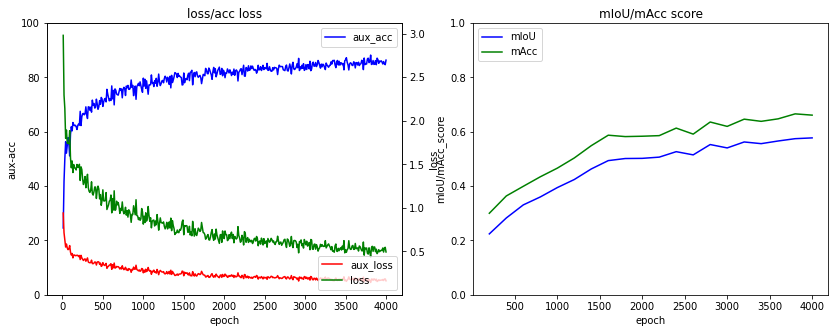

In [14]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(14, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax2 = ax1.twinx()
line1, = ax2.plot(x_epoch_data,aux_loss,label='aux_loss',color='red') 
line2, = ax1.plot(x_epoch_data,aux_acc,label='aux_acc',color='blue')
line3, = ax2.plot(x_epoch_data,loss,label='loss',color='green')
ax1.set_title("loss/acc loss")
ax1.set_xlabel('epoch')
ax1.set_ylabel('aux-acc')
ax2.set_ylabel('loss')
ax1.set_ylim(0, 100)
ax1.legend(loc='upper right')
ax2.legend(loc='lower right')

ax3 = fig.add_subplot(1, 2, 2)
line1, = ax3.plot(x_epoch_data_2,mIou,label='mIoU',color='blue')
line2, = ax3.plot(x_epoch_data_2,mAcc,label='mAcc',color='green') 
ax3.set_title("mIoU/mAcc score")
ax3.set_xlabel('epoch')
ax3.set_ylabel('mIoU/mAcc_score')
ax3.set_ylim(0, 1)
ax3.legend(loc='upper left')

plt.show()


In [15]:
cfg_file = cfg.pretty_text
cfg_path = './work_dirs/tutorial_deeplabv3_r50A/cfg.py'

with open(cfg_path, mode='w') as f:
    f.write(cfg_file)

In [16]:
#mmsegmentationの実行のロード（GPUあり）
from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot

config_file = cfg_path #configファイルのパス
checkpoint_file = 'work_dirs/tutorial_deeplabv3_r50A/latest.pth' #学習済みの最終モデル

model = init_segmentor(config_file, checkpoint_file, device='cuda:0')

load checkpoint from local path: work_dirs/tutorial_deeplabv3_r50A/latest.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


<Figure size 576x432 with 0 Axes>

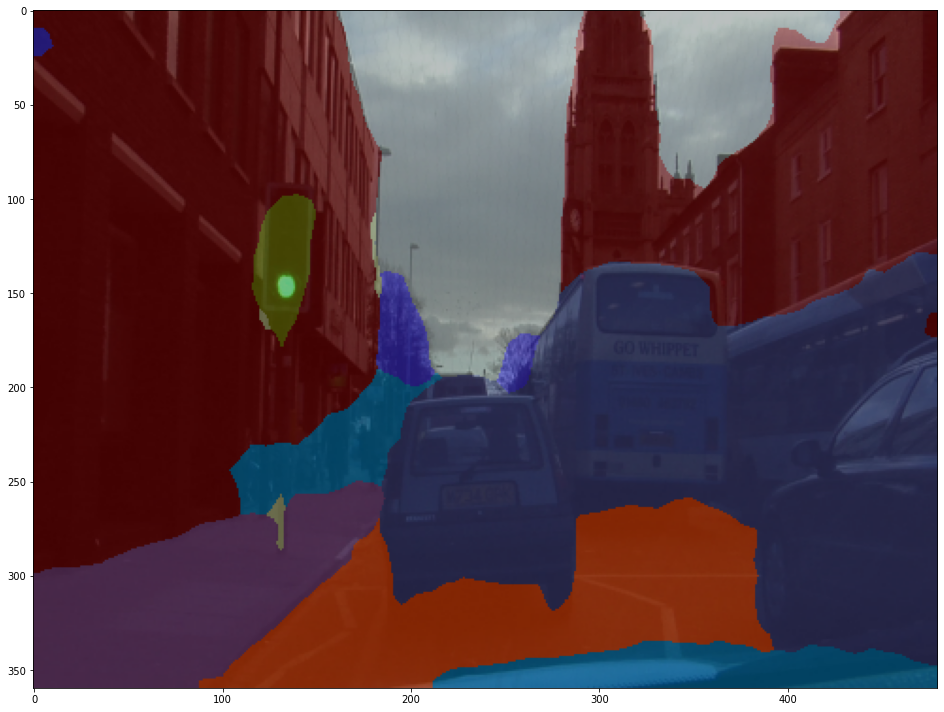

In [17]:
img = mmcv.imread('/content/data/CamVid/train/0001TP_006690.png')

model.cfg = cfg
result = inference_segmentor(model, img)
plt.figure(figsize=(8, 6))
show_result_pyplot(model, img, result, palette)

In [ ]:
#@title dataset
# train -> 元の画像、trainannot -> segmentationした画像, train.txtに画像のパス

In [ ]:
# mmsegmentationのrgb, maskのデータセットの作成の仕方
# shape - (height, width, 3)
# labelがあるpixelに関してはそこの値は[label_id, label_id, label_id]として埋めて.pngで保存しておく。

In [18]:
import cv2
import numpy as np
img_name = "0001TP_008550.png"
rgb_img = cv2.imread(f"/content/data/CamVid/test/{img_name}")
mask_img = cv2.imread(f"/content/data/CamVid/testannot/{img_name}")

In [28]:
np.unique(mask_img)

array([ 0,  1,  2,  3,  4,  5,  6,  8,  9, 10, 11], dtype=uint8)

In [21]:
def show_mask(mask_img, label_id):
  new_mask_img = np.zeros_like(mask_img)
  for i in range(mask_img.shape[0]):
    for j in range(mask_img.shape[1]):
      if mask_img[i, j, 0] == label_id:
        new_mask_img[i, j, :] = [255, 0, 0]
  return new_mask_img

In [33]:
new_mask_img = show_mask(mask_img, 3)

In [ ]:
from PIL import Image
pil_new_mask = Image.fromarray(new_mask_img)
display(pil_new_mask)